# Team Assignment - Jupyter Notebook 

**The following additional installations are required to run all cells:**  

- `pip install tensorflow`
- `pip install keras-tuner`
- `conda install -c anaconda graphviz` and `conda install -c conda-forge python-graphviz`
- `pip install pydot`

# 1. Data Collection and Preparation

In the next steps, we import the necessary packages and load our datasets. We first start with the charging sessiong dataset.

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Charging Dataset Overview:

In [2]:
# import dataset
dfCharging = pd.read_csv("Data/charging_sessions.csv")
dfCharging.head()

Unnamed: 0                        id             connectionTime  \
0           0  5e23b149f9af8b5fe4b973cf  2020-01-02 13:08:54+00:00   
1           1  5e23b149f9af8b5fe4b973d0  2020-01-02 13:36:50+00:00   
2           2  5e23b149f9af8b5fe4b973d1  2020-01-02 13:56:35+00:00   
3           3  5e23b149f9af8b5fe4b973d2  2020-01-02 13:59:58+00:00   
4           4  5e23b149f9af8b5fe4b973d3  2020-01-02 14:00:01+00:00   

              disconnectTime           doneChargingTime  kWhDelivered  \
0  2020-01-02 19:11:15+00:00  2020-01-02 17:31:35+00:00        25.016   
1  2020-01-02 22:38:21+00:00  2020-01-02 20:18:05+00:00        33.097   
2  2020-01-03 00:39:22+00:00  2020-01-02 16:35:06+00:00         6.521   
3  2020-01-02 16:38:39+00:00  2020-01-02 15:18:45+00:00         2.355   
4  2020-01-02 22:08:40+00:00  2020-01-02 18:17:30+00:00        13.375   

                                sessionID  siteID  spaceID    stationID  \
0  1_1_179_810_2020-01-02 13:08:53.870034       1  AG-3F30  1-1-179-810   
1  1_1_193_825_2020-01-02 13:36:49.599853       1  AG-1F01  1-1-193-825   
2  1_1_193_829_2020-01-02 13:56:35.214993       1  AG-1F03  1-1-193-829   
3  1_1_193_820_2020-01-02 13:59:58.309319       1  AG-1F04  1-1-193-820   
4  1_1_193_819_2020-01-02 14:00:00.779967       1  AG-1F06  1-1-193-819   

              timezone  userID  \
0  America/Los_Angeles   194.0   
1  America/Los_Angeles  4275.0   
2  America/Los_Angeles   344.0   
3  America/Los_Angeles  1117.0   
4  America/Los_Angeles   334.0   

                                          userInputs  
0  [{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil...  
1  [{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil...  
2  [{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...  
3  [{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...  
4  [{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil...

In [3]:
dfCharging.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        66450 non-null  int64  
 1   id                66450 non-null  object 
 2   connectionTime    66450 non-null  object 
 3   disconnectTime    66450 non-null  object 
 4   doneChargingTime  62362 non-null  object 
 5   kWhDelivered      66450 non-null  float64
 6   sessionID         66450 non-null  object 
 7   siteID            66450 non-null  int64  
 8   spaceID           66450 non-null  object 
 9   stationID         66450 non-null  object 
 10  timezone          66450 non-null  object 
 11  userID            49187 non-null  float64
 12  userInputs        49187 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 6.6+ MB


In [4]:
#remove the first "Unnamed" Column
dfCharging = dfCharging.drop('Unnamed: 0', axis=1)
dfCharging.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                66450 non-null  object 
 1   connectionTime    66450 non-null  object 
 2   disconnectTime    66450 non-null  object 
 3   doneChargingTime  62362 non-null  object 
 4   kWhDelivered      66450 non-null  float64
 5   sessionID         66450 non-null  object 
 6   siteID            66450 non-null  int64  
 7   spaceID           66450 non-null  object 
 8   stationID         66450 non-null  object 
 9   timezone          66450 non-null  object 
 10  userID            49187 non-null  float64
 11  userInputs        49187 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 6.1+ MB


### Remove duplicates

In [5]:
# test if there a duplicate rows
len(dfCharging)-len(dfCharging.drop_duplicates())

1413

In [6]:
# remove duplicate rows
dfCharging = dfCharging.drop_duplicates()

### Check for missing values

In [7]:
print(dfCharging.isnull().sum())

id                      0
connectionTime          0
disconnectTime          0
doneChargingTime     4087
kWhDelivered            0
sessionID               0
siteID                  0
spaceID                 0
stationID               0
timezone                0
userID              17215
userInputs          17215
dtype: int64


We note that the columns , 'userID', 'userInputs' and 'doneChargingTime' have a considerable number of missing values.

### Investigate "userId" and "userInputs"
First we check if the 'userID' matches the 'userInputs'

In [8]:
# Check whether the lines with missing 'userInputs' also have missing 'userID'
missing_userInputs = dfCharging['userInputs'].isnull()
missing_userID = dfCharging['userID'].isnull()

# Check that the missing values match
matching_missing = dfCharging[missing_userInputs & missing_userID]

# Output the number of matching lines
print(f'Number of lines with missing "userID" and "userIputs": {len(matching_missing)}')

# Calculate percentage of match
total_missing_userInputs = len(dfCharging[missing_userInputs])
if total_missing_userInputs > 0:
    matching_percentage = (len(matching_missing) / total_missing_userInputs) * 100
    print(f'Percentage of compliance: {matching_percentage:.2f}%')


Number of lines with missing "userID" and "userIputs": 17215
Percentage of compliance: 100.00%


But another important point could be to check out if the amount of missing data in these columns is significantly high

In [9]:
#Calculate total amount of observations recorded
total_observations_userID = len(dfCharging["userID"])
total_observations_userInputs = len(dfCharging["userInputs"])

#Calculate the amount of missing data
total_missing_userID = dfCharging["userID"].isnull().sum()
total_missing_userInputs = dfCharging["userInputs"].isnull().sum()

#Calculate the percentage of missing values
percentage_missing_userID = 100 * total_missing_userID / total_observations_userID
percentage_missing_userInputs = 100 * total_missing_userInputs / total_observations_userInputs

#Print the results
print("The percentage of missing data in userID:", percentage_missing_userID)
print("The percentage of missing data in userInputs:", percentage_missing_userInputs)



The percentage of missing data in userID: 26.469548103387304
The percentage of missing data in userInputs: 26.469548103387304


### Investigate "doneChargingtime"

In [10]:
#Calculate total amount of observations recorded
total_observations_doneChargingTime = len(dfCharging["doneChargingTime"])

#Calculate the amount of missing data
total_missing_doneChargingTime = dfCharging["doneChargingTime"].isnull().sum()

#Calculate the percentage of missing values
percentage_missing_doneChargingTime = 100 * total_missing_doneChargingTime / total_observations_doneChargingTime

#Print the results
print("The percentage of missing data in doneChargingTime:", percentage_missing_doneChargingTime)

The percentage of missing data in doneChargingTime: 6.284115195965374


## Transformation of Features

### Create separate columns for the features within "userInputs" to facilitate access

In [11]:
#methods for creation of "userInputs" columns

#transform 'userInputs' object to dictionary data type
def userInputStringToDictionary(entry):
    
    s = str(entry).replace("\'", "\"").replace("True", "1").replace("False","0")
    return json.loads(s)[0]

#return feature value from dictionary 'userInputs'
def returnUserInputFeature(entry, feature):
    
    return entry[feature]


In [12]:
#Transform 'userInputs' into dictionary type
dfCharging['userInputs'] = dfCharging[~dfCharging['userInputs'].isna()]['userInputs'].apply(userInputStringToDictionary)


#create a column for each "userInput" feature
userInput_features = ['WhPerMile', 'kWhRequested', 'milesRequested', 'minutesAvailable', 
                      'modifiedAt', 'paymentRequired', 'requestedDeparture']

for feature in userInput_features:
    
    dfCharging[feature] = dfCharging[~dfCharging['userInputs'].isna()]['userInputs'].apply(returnUserInputFeature, feature=feature)
    
#drop column "userInputs"
dfCharging = dfCharging.drop('userInputs', axis=1)
                      

### Timestamp fetaures to data type timestamp

 All observations are within the same timezone:

In [13]:
print(dfCharging['timezone'].describe())

count                   65037
unique                      1
top       America/Los_Angeles
freq                    65037
Name: timezone, dtype: object


In [14]:
#get the timezone
timezone = dfCharging['timezone'].unique()[0]

# Convert to datetime and convert to the actual timezone
dfCharging['connectionTime'] = pd.to_datetime(dfCharging['connectionTime'], utc=True).dt.tz_convert(timezone)
dfCharging['doneChargingTime'] = pd.to_datetime(dfCharging['doneChargingTime'], utc=True).dt.tz_convert(timezone)
dfCharging['disconnectTime'] = pd.to_datetime(dfCharging['disconnectTime'], utc=True).dt.tz_convert(timezone)
dfCharging['modifiedAt'] = pd.to_datetime(dfCharging['modifiedAt'], utc=True).dt.tz_convert(timezone)
dfCharging['requestedDeparture'] = pd.to_datetime(dfCharging['requestedDeparture'], utc=True).dt.tz_convert(timezone)

## Dealing with Missing Data

From the previous operations we see that almost a quarter of our data in these columns are missing. Therefore, we now have to decide how to deal with the missing data

- Do we remove the rows with the missing data?

- Do we keep the rows but ignore that these values are missing?

- Do we consider ways to impute the missing values?

### Decision "userId" and "userInputs":

Since the missing values can't be calculated or derived from the other features, we have to decide if we remove features/observations with missing features or if we keep them. Later, we will perform different types of analyses which will focus on different features. Hence, we can't make a general decision now and postpone the decision to the single analyses tasks. If the "userInputs" will be required, we will remove observations that do not have them, if the "userInputs" are not required, we will just remove the respective features and keep all observations.

Thus, we can maximizie our available data. 

### Decision "doneChargingTime":

Another column with a lot of missing data is the "doneChargingTime" column.

First we will check if doneChargingTime can be derived from other features.

'doneChargingTime' is defined as: Time when of the last non-zero current draw recorded.
What happens if a user request of kWh is not fullfilled, will the charging process continue until the car disconnects?

In [15]:
#
nrSamplesNanDoneChargingTime = dfCharging[dfCharging['doneChargingTime'].isna()].shape[0]
nrSamplesNanDoneChargingTimeButWithUserInputs = dfCharging[(dfCharging['doneChargingTime'].isna()) & (dfCharging['userID'].notnull())].shape[0]
nrSamplesNanDoneChargingTimeAndNotDeliveredKwh = dfCharging[(dfCharging['doneChargingTime'].isna()) & (dfCharging['kWhRequested'] > dfCharging['kWhDelivered'])].shape[0]

print(str(nrSamplesNanDoneChargingTimeButWithUserInputs/nrSamplesNanDoneChargingTime) + "% of the samples where doneChargingTime is missing have userInputs")

print(str(nrSamplesNanDoneChargingTimeAndNotDeliveredKwh/nrSamplesNanDoneChargingTime) + '% of the samples where doneChargingTime is missing have not fullfiled the kWh request')


0.7775874724736971% of the samples where doneChargingTime is missing have userInputs
0.705162711034989% of the samples where doneChargingTime is missing have not fullfiled the kWh request


If it means that when the kWh request was not fullfiled, the doneChargingTime is just the disconnectTime, then we could fill 71% of the missing doneChargingTime values.

So lets have a look at the samples with doneChargingTime and not fullfiled kWh Request. Is it true that doneChargingTime == disconnectTime?


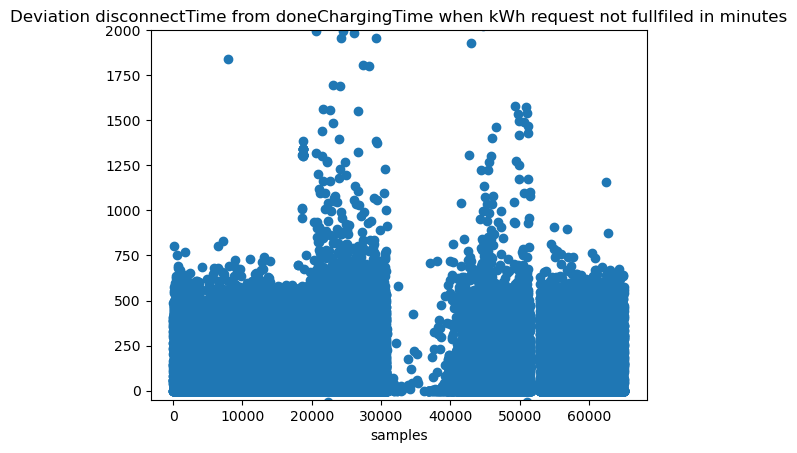

In [16]:
def calcDiffDisconnectAndDoneCharging(entry):
    
    return (entry['disconnectTime']-entry['doneChargingTime']).total_seconds()/60


samplesNanDoneChargingTimeAndNotDeliveredKwh = dfCharging[(dfCharging['doneChargingTime'].notnull()) & (dfCharging['kWhRequested'] > dfCharging['kWhDelivered'])].copy()
samplesNanDoneChargingTimeAndNotDeliveredKwh['deviationDisconnect'] = samplesNanDoneChargingTimeAndNotDeliveredKwh.apply(lambda row: calcDiffDisconnectAndDoneCharging(row), axis=1)

#plot the deviation
plt.scatter(samplesNanDoneChargingTimeAndNotDeliveredKwh.index, samplesNanDoneChargingTimeAndNotDeliveredKwh['deviationDisconnect'], marker='o', linestyle='-')
plt.ylim(bottom=-50, top=2000)
plt.xlabel('samples')
plt.title('Deviation disconnectTime from doneChargingTime when kWh request not fullfiled in minutes')
plt.show()

We see that there exist huge deviations between disconnectTime and doneChargingTime when kWh request is not fullfiled. So we cant just set the missing values to be the disconnectTime where kWh request is not fullfiled.
Probably the utilization of the stations and other factors influence the doneChargingTime

Which also raises questions as to why, in cases with a deviation of more than e.g. 10 hours, the kWh request was not fullfilled


Can we just use 'minutesAvailable' and 'requestedkWh' to estimate 'doneChargingTime'?

Is the rate of the delivered kWh just stretched to the expected time of availability? Lets look at samples with 'doneChargingTime' and fullfilled kWhRequest. Does the 'doneChargingTime' equal 'requestedDeparture'?


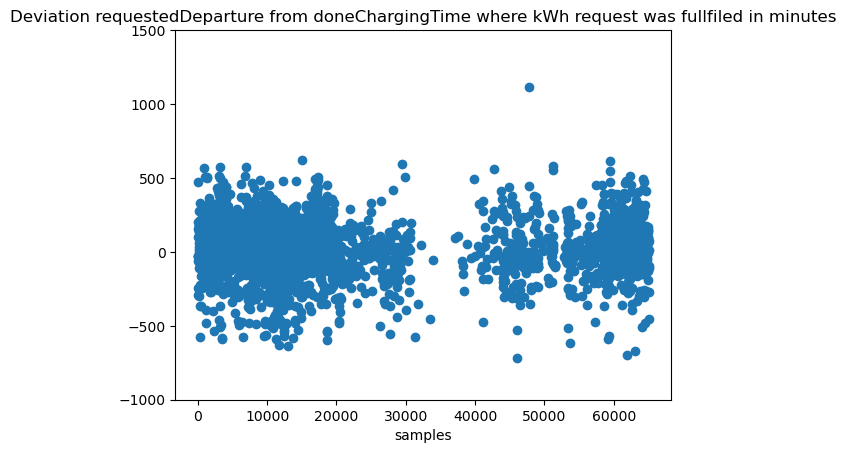

In [17]:
def calcDiffDepartAndDoneCharging(entry):
    
    return (entry['requestedDeparture']-entry['doneChargingTime']).total_seconds()/60


dfDeliveredKwh = dfCharging[(dfCharging['doneChargingTime'].notnull()) & (dfCharging['kWhRequested'] <= dfCharging['kWhDelivered'])].copy()
dfCalc = dfDeliveredKwh.apply(lambda row: calcDiffDepartAndDoneCharging(row), axis=1)

#plot the deviation
plt.scatter(dfDeliveredKwh.index, dfCalc, marker='o', linestyle='-')
plt.ylim(bottom=-1000, top=1500)  
plt.xlabel('samples')
plt.title('Deviation requestedDeparture from doneChargingTime where kWh request was fullfiled in minutes')
plt.show()

Positive values mean that the 'doneChargingTime' was before the originally requested departure time. Negative values mean that the actual departure was later than requested originally and the 'doneChargingTime' was also after the originally requested departure time.\

Too many significant deviations from 'requestedDeparture' and 'doneChargingTime'.

The results strongly suggests that you have to look very closely at the utilisation of the stations here. But there could also be another logic behind the charging scheduling which is not deducible from the given dataset.

##### Since "only" 6% of the samples are missing doneChargingTime, and we would need to make assumptions that we are not sure about to further investigate this matter, and we dont know how important this feature will be for our further work at this moment, we just leave it like it is. Later we can consider if we drop the samples with missing values or drop the feature itself or make further investigations.

### Decision Weather Dataset

In [18]:
#Load the weather data from burbank airport
dfWeather = pd.read_csv("Data/weather_burbank_airport.csv")
dfWeather.head()

city            timestamp  temperature  cloud_cover  \
0  Burbank  2018-01-01 08:53:00          9.0         33.0   
1  Burbank  2018-01-01 09:53:00          9.0         33.0   
2  Burbank  2018-01-01 10:53:00          9.0         21.0   
3  Burbank  2018-01-01 11:53:00          9.0         29.0   
4  Burbank  2018-01-01 12:53:00          8.0         33.0   

  cloud_cover_description  pressure  windspeed  precipitation  \
0                    Fair    991.75        9.0            0.0   
1                    Fair    992.08        0.0            0.0   
2                    Haze    992.08        0.0            0.0   
3           Partly Cloudy    992.08        0.0            0.0   
4                    Fair    992.08        0.0            0.0   

   felt_temperature  
0               8.0  
1               9.0  
2               9.0  
3               9.0  
4               8.0

In [19]:
dfWeather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city                     29244 non-null  object 
 1   timestamp                29244 non-null  object 
 2   temperature              29219 non-null  float64
 3   cloud_cover              29224 non-null  float64
 4   cloud_cover_description  29224 non-null  object 
 5   pressure                 29236 non-null  float64
 6   windspeed                29158 non-null  float64
 7   precipitation            29244 non-null  float64
 8   felt_temperature         29218 non-null  float64
dtypes: float64(6), object(3)
memory usage: 2.0+ MB


In [20]:
# test if there a duplicate rows
len(dfWeather)-len(dfWeather.drop_duplicates())

0

No duplicates existent

In [21]:
# Check for missing values
print(dfWeather.isnull().sum())

city                        0
timestamp                   0
temperature                25
cloud_cover                20
cloud_cover_description    20
pressure                    8
windspeed                  86
precipitation               0
felt_temperature           26
dtype: int64


The columns , ‘temperature’, ‘cloud_cover’, 'cloud_cover_description', 'pressure', 'windspeed' and ‘felt_temperature’ have a number of missing values.

First we check if missing 'cloud_cover' also has missing 'cloud_cover_description'

In [22]:
# Check whether the lines with missing 'cloud_cover' also have missing 'cloud_cover_description'
missing_cloud_cover = dfWeather['cloud_cover'].isnull()
missing_cloud_cover_description = dfWeather['cloud_cover_description'].isnull()

# Check that the missing values match
matching_missing = dfWeather[missing_cloud_cover & missing_cloud_cover_description]

# Output the number of matching lines
print(f'Number of lines with missing "cloud_cover" and "cloud_cover_description": {len(matching_missing)}')

# Calculate percentage of match
total_missing_cloud_cover = len(dfWeather[missing_cloud_cover])
if total_missing_cloud_cover > 0:
    matching_percentage = (len(matching_missing) / total_missing_cloud_cover) * 100
    print(f'Percentage of compliance: {matching_percentage:.2f}%')

Number of lines with missing "cloud_cover" and "cloud_cover_description": 20
Percentage of compliance: 100.00%


At this point we could again check if the amount of missing data is significantly high

In [23]:
#Calculate total amount of observations recorded
total_observations_cloud_cover = len(dfWeather["cloud_cover"])
total_observations_cloud_cover_description = len(dfWeather["cloud_cover_description"])

#Calculate the amount of missing data
total_missing_cloud_cover = dfWeather["cloud_cover"].isnull().sum()
total_missing_cloud_cover_description = dfWeather["cloud_cover_description"].isnull().sum()

#Calculate the percentage of missing values
percentage_missing_cloud_cover = 100 * total_missing_cloud_cover / total_observations_cloud_cover
percentage_missing_cloud_cover_description = 100 * total_missing_cloud_cover_description / total_observations_cloud_cover_description

#Print the results
print("The percentage of missing data in cloud_cover:", percentage_missing_cloud_cover)
print("The percentage of missing data in cloud_cover_description:", percentage_missing_cloud_cover_description)



The percentage of missing data in cloud_cover: 0.0683900971139379
The percentage of missing data in cloud_cover_description: 0.0683900971139379


We see that only 0,068% of our data is missing. We now could check the other columns with missing values to see how much of our data is missing there. We build a a for loop to do this faster. 

In [24]:
# List of columns to check for missing values
columns_to_check = ["temperature", "pressure", "windspeed", "felt_temperature"] 

for column in columns_to_check:
    total_observations = len(dfWeather[column])
    total_missing = dfWeather[column].isnull().sum()
    percentage_missing = 100 * total_missing / total_observations
    print(f"Percentage of missing values in {column}: {percentage_missing:.2f}%")


Percentage of missing values in temperature: 0.09%
Percentage of missing values in pressure: 0.03%
Percentage of missing values in windspeed: 0.29%
Percentage of missing values in felt_temperature: 0.09%


For **weather data** we decide apply to mean imputation for the following columns:

- temperature
- cloud cover
- pressure
- windspeed
- felt temperature

In [25]:
# Sort the DataFrame by timestamp
dfWeather.sort_values(by='timestamp', inplace=True)

# Function to impute missing values using the mean of neighboring values
def impute_missing_values(column, window_size=5):
    # Calculate the mean using a rolling window
    # We have to use a window for the cases where some neighboring values are also missing.
    return column.fillna(column.rolling(window=window_size, min_periods=1).mean())

# Apply the imputation function to the specified columns
columns_to_impute = ['temperature', 'cloud_cover', 'windspeed', 'pressure',"felt_temperature"]

for column in columns_to_impute:
    dfWeather[column] = impute_missing_values(dfWeather[column])

# Verify the changes
print(dfWeather.isnull().sum())



city                        0
timestamp                   0
temperature                 0
cloud_cover                 0
cloud_cover_description    20
pressure                    0
windspeed                   0
precipitation               0
felt_temperature            0
dtype: int64


In [26]:
def fill_missing_cloud_cover_description(dfWeather):
    dfWeather = dfWeather.sort_values(by='timestamp')  # Actually not needed because of the previous function

    for index, row in dfWeather.iterrows():
        if pd.isnull(row['cloud_cover_description']):
            # Round the 'cloud_cover' value
            rounded_cloud_cover = round(row['cloud_cover'])

            # Try to find a match with the rounded 'cloud_cover'
            matching_rows = dfWeather[(round(dfWeather['cloud_cover']) == rounded_cloud_cover) & (~pd.isnull(dfWeather['cloud_cover_description']))]

            if not matching_rows.empty:
                matching_description = matching_rows['cloud_cover_description'].values[0]
                dfWeather.at[index, 'cloud_cover_description'] = matching_description
            else:
                # If no match is found, try to find a match for 'rounded_cloud_cover + 1'
                next_matching_rows = dfWeather[(round(dfWeather['cloud_cover']) == rounded_cloud_cover + 1) & (~pd.isnull(dfWeather['cloud_cover_description']))]

                if not next_matching_rows.empty:
                    next_matching_description = next_matching_rows['cloud_cover_description'].values[0]
                    dfWeather.at[index, 'cloud_cover_description'] = next_matching_description

    return dfWeather

dfWeather = fill_missing_cloud_cover_description(dfWeather)

# Verify the changes
print(dfWeather.isnull().sum())


city                       0
timestamp                  0
temperature                0
cloud_cover                0
cloud_cover_description    0
pressure                   0
windspeed                  0
precipitation              0
felt_temperature           0
dtype: int64


## Next Steps


- Merge charging and weather data
- Look for the amount missing values in weather data after merging
- Check if there are other weather data available somewhere else
- (Maybe) separate charging data depending on sideID and check for doneCharging/disconnectTime differences

## Merging the two DataFrames

In [27]:
dfWeather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city                     29244 non-null  object 
 1   timestamp                29244 non-null  object 
 2   temperature              29244 non-null  float64
 3   cloud_cover              29244 non-null  float64
 4   cloud_cover_description  29244 non-null  object 
 5   pressure                 29244 non-null  float64
 6   windspeed                29244 non-null  float64
 7   precipitation            29244 non-null  float64
 8   felt_temperature         29244 non-null  float64
dtypes: float64(6), object(3)
memory usage: 2.0+ MB


Check the distribution of the temperature values to find out, if the timestamps are in UTC as well and need to be converted to the right timezone:

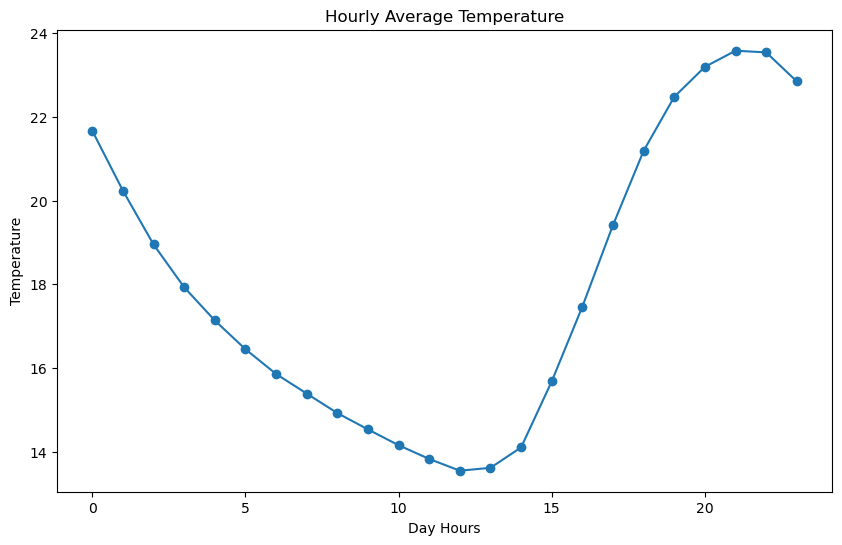

In [28]:
# Convert the type object to datetime
dfWeather["timestamp"] = pd.to_datetime(dfWeather["timestamp"], utc=True)

hourly_avg_temp = []

for i in range(0,24):
    
    hourly_avg_temp.append(dfWeather[dfWeather["timestamp"].dt.hour == i]['temperature'].mean())
    

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(hourly_avg_temp, marker='o')
plt.xlabel('Day Hours')
plt.ylabel('Temperature')
plt.title('Hourly Average Temperature')
plt.show()

Since the lowest average temperature is reached at noon and the highest at 9pm, it must be converted to the right timezone:

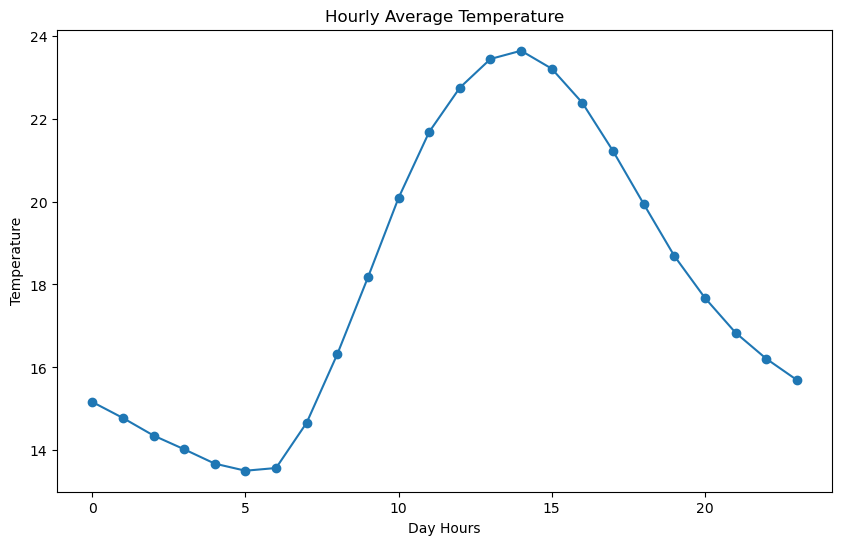

In [29]:
#get the timezone
timezone = dfCharging['timezone'].unique()[0]

# Convert to datetime and convert to the actual timezone
dfWeather["timestamp"] = dfWeather["timestamp"].dt.tz_convert(timezone)

#Check again the distribution
hourly_avg_temp = []

for i in range(0,24):
    
    hourly_avg_temp.append(dfWeather[dfWeather["timestamp"].dt.hour == i]['temperature'].mean())
    

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(hourly_avg_temp, marker='o')

# Add labels and title
plt.xlabel('Day Hours')
plt.ylabel('Temperature')
plt.title('Hourly Average Temperature')
plt.show()

**Now the distribution seems reasonable.**

In [30]:
# Sort values for merge_asof to work
dfCharging.sort_values('connectionTime', inplace=True)
dfWeather.sort_values('timestamp', inplace=True)

# Merge the two datasets according to their timestamps. 
# Use merge_asof to merge according to the nearest timestamp found in dfWeather with a tolerance of 5 hours
dfMerged = pd.merge_asof(dfCharging, dfWeather, left_on = "connectionTime", right_on = "timestamp", tolerance = pd.Timedelta(hours=5))
    

In [31]:
dfMerged.isnull().sum()

id                             0
connectionTime                 0
disconnectTime                 0
doneChargingTime            4087
kWhDelivered                   0
sessionID                      0
siteID                         0
spaceID                        0
stationID                      0
timezone                       0
userID                     17215
WhPerMile                  17215
kWhRequested               17215
milesRequested             17215
minutesAvailable           17215
modifiedAt                 17215
paymentRequired            17215
requestedDeparture         17215
city                        9013
timestamp                   9013
temperature                 9013
cloud_cover                 9013
cloud_cover_description     9013
pressure                    9013
windspeed                   9013
precipitation               9013
felt_temperature            9013
dtype: int64

**We are missing weather data for 9013 observations in the charging data.**

Since we couldn't find additional data from further resources, we accept this situation.

**Here too, a decision must be made on a case-by-case basis as to whether the weather data or the observations without weather data are dispensed with.**

# 2. Descriptive Analytics

## a) Temporal Patterns and Seasonality:

##### Investigate seasonal patterns:

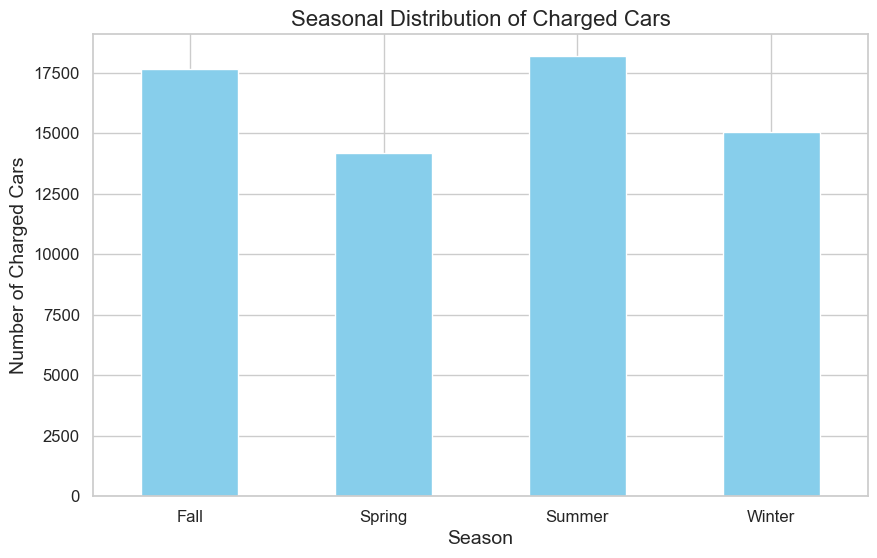

In [32]:
# Create a new column for the season based on the month
dfCharging['season'] = dfCharging['connectionTime'].dt.month.map(
    {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer',
     7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'})

# Group by season and count the number of charged cars in each season
seasonal_counts = dfCharging.groupby('season').size()

# Set the style using seaborn
sns.set(style="whitegrid")

# Plot the results with improved styling
plt.figure(figsize=(10, 6))
seasonal_counts.plot(kind='bar', color='skyblue')
plt.title('Seasonal Distribution of Charged Cars', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Number of Charged Cars', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

From this chart we see that the seasons with the highest demand are summer and fall.

Observation: The drop in spring could be due to the spring break in the universities.

It could also be interesting to know the average temperatures of every season to understand what kind of a climate our city has.


In [33]:
# Create a new column for the season based on the month
dfWeather['season'] = dfWeather['timestamp'].dt.month.map(
    {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer',
     7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'})

# Group by season and calculate the average temperature for each season
average_temperature_by_season = dfWeather.groupby('season')['temperature'].mean()

# Create a pivot table to calculate the average temperature for each season
pivot_table = pd.pivot_table(dfWeather, values='temperature', index='season', aggfunc='mean')

# Display the pivot table
print(pivot_table)

        temperature
season             
Fall      19.825194
Spring    16.074278
Summer    22.730034
Winter    13.116715


From these results we see that our city has a very mild climate, which could explain the absense of big seasonal fluctations in demand.

##### Investigate weekly patterns:

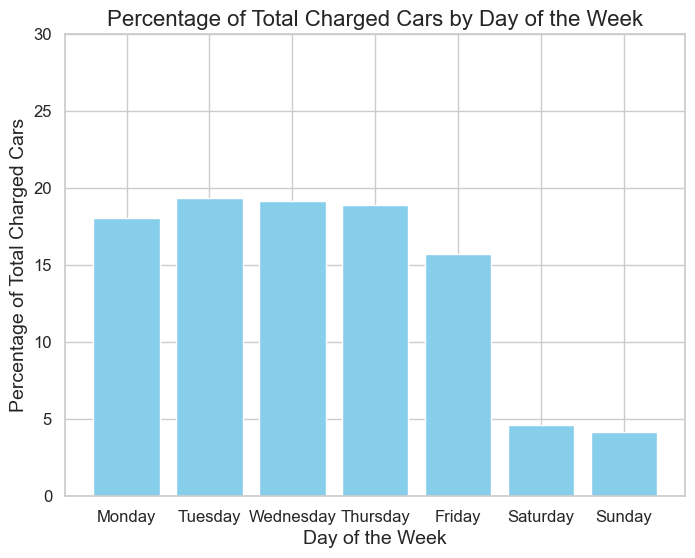

In [34]:
# Create a new column for the day of the week (Monday=0, Sunday=6)
dfCharging['day_of_week'] = dfCharging['connectionTime'].dt.dayofweek

# Count the number of occurrences for each day of the week
counts_by_day = dfCharging['day_of_week'].value_counts()

# Calculate the percentage of total demand for each day of the week
percentage_demand_by_day = (counts_by_day / counts_by_day.sum()) * 100

# Plot the results with a bar chart
plt.figure(figsize=(8, 6))
plt.bar(percentage_demand_by_day.index, percentage_demand_by_day, color='skyblue')

plt.title('Percentage of Total Charged Cars by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Percentage of Total Charged Cars', fontsize=14)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 30)  # Set the y-axis limit to ensure it starts from 0
plt.show()

From this chart we can identify that the demand level on the weekdays is high and stays high until the weekends. In the weekends the demand is quite low.


##### Investigate daily patterns:

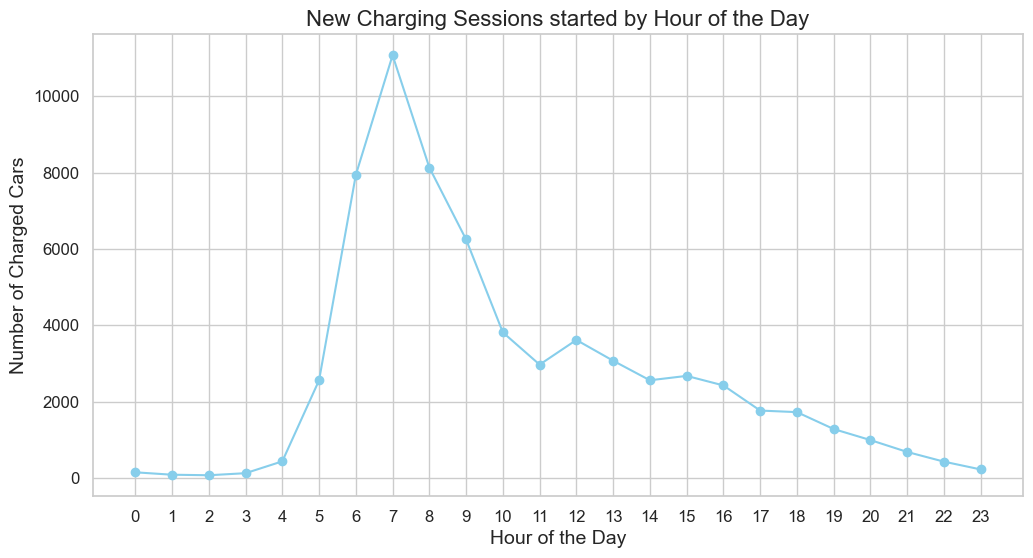

In [35]:
# Create a new column for the hour of the day
dfCharging['hour_of_day'] = dfCharging['connectionTime'].dt.hour 
# Count the number of occurrences for each hour of the day
counts_by_hour = dfCharging['hour_of_day'].value_counts().sort_index()

# Plot the results with a line chart
plt.figure(figsize=(12, 6))
plt.plot(counts_by_hour.index, counts_by_hour, marker='o', linestyle='-', color='skyblue')

plt.title('New Charging Sessions started by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Number of Charged Cars', fontsize=14)
plt.xticks(range(24), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# !!Explain!!

## b) Key Performance Indicators (KPIs):

We decicded for the KPIs:
- Absolute utilization: Nr. of currently connected vehiclesAverage kWh requested per user.
- Average kWh requested per user in the last hour (only available from users with "userInputs" .
- Currently parking but not charging.

In [36]:
#get the respective features
dfKPIs = dfCharging[['connectionTime','disconnectTime', 'doneChargingTime', 'siteID', 'kWhRequested']].copy()

def createConnectionTimeLastHour(row):
    
    return row.replace(second=0, minute=0)+pd.DateOffset(hours=1)
    

dfKPIs['connectionTimeHourBefore'] = dfKPIs['connectionTime'].apply(createConnectionTimeLastHour)

Create a dataframe with hourly entries over the time period that is covered by our charging data and calculate the hourly KPI values:

In [37]:
#get the boundaries of the mentioned time period
startTimestamp = min(dfKPIs['connectionTime'].min(),dfKPIs['disconnectTime'].min()).replace(microsecond=0, second=0, minute=0)
endTimestamp = max(dfKPIs['connectionTime'].max(),dfKPIs['disconnectTime'].max()).replace(microsecond=0, second=0, minute=0) + pd.DateOffset(hours=1)

#create the hourly dataframe
dfHourly = pd.DataFrame({'hours': pd.date_range(startTimestamp, endTimestamp, freq='1H')})

#add cloumns for the 3 KPIs:
    #1. Absolute utilization
    #2. Average kWh requested per user
    #3. Currently parking but not charging
dfHourly['absUtilization1'] = 0
dfHourly['absUtilization2'] = 0
dfHourly['avg_kWhRequested1'] = 0
dfHourly['avg_kWhRequested2'] = 0
dfHourly['absBlocking1'] = 0
dfHourly['absBlocking2'] = 0


In [38]:
#calculate the hourly KPIs
for index, row in dfHourly.iterrows():
    
    dfHourly.at[index, 'absUtilization1'] = dfKPIs[(dfKPIs['siteID'] == 1) & 
                                                 (dfKPIs['connectionTime'] <= row['hours']) & 
                                                 (dfKPIs['disconnectTime'] >= row['hours'])].shape[0]
    dfHourly.at[index, 'absUtilization2'] = dfKPIs[(dfKPIs['siteID'] == 2) & 
                                                 (dfKPIs['connectionTime'] <= row['hours']) & 
                                                 (dfKPIs['disconnectTime'] >= row['hours'])].shape[0]
    dfHourly.at[index, 'avg_kWhRequested1'] = dfKPIs[(dfKPIs['kWhRequested'].notnull()) &
                                                  (dfKPIs['siteID'] == 1) &
                                                 (dfKPIs['connectionTimeHourBefore'] == row['hours'])]['kWhRequested'].mean()
    dfHourly.at[index, 'avg_kWhRequested2'] = dfKPIs[(dfKPIs['kWhRequested'].notnull()) &
                                                  (dfKPIs['siteID'] == 2) &
                                                 (dfKPIs['connectionTimeHourBefore'] == row['hours'])]['kWhRequested'].mean()
    dfHourly.at[index, 'absBlocking1'] = dfKPIs[(dfKPIs['doneChargingTime'].notnull()) & 
                                                    (dfKPIs['siteID'] == 1) & 
                                                 (dfKPIs['doneChargingTime'] <= row['hours']) & 
                                                 (dfKPIs['disconnectTime'] >= row['hours'])].shape[0]
    dfHourly.at[index, 'absBlocking2'] = dfKPIs[(dfKPIs['doneChargingTime'].notnull()) & 
                                                    (dfKPIs['siteID'] == 2) & 
                                                 (dfKPIs['doneChargingTime'] <= row['hours']) & 
                                                 (dfKPIs['disconnectTime'] >= row['hours'])].shape[0]


In [39]:
# fill Nan in kWhRequeste with 0 to have meaningful results
dfHourly.loc[dfHourly['avg_kWhRequested1'].isnull(),'avg_kWhRequested1'] = 0
dfHourly.loc[dfHourly['avg_kWhRequested2'].isnull(),'avg_kWhRequested2'] = 0

Plotting preparation - Calculate the average KPI values per hour of the day over the whole time period covered by the charging data:

In [40]:
#init dataframe with one entry for every hour of the day and add respective KPI columns
dfPlotKPI = pd.DataFrame({'hours': range(24)})
dfPlotKPI['avgUtilization1'] = 0
dfPlotKPI['avgUtilization2'] = 0
dfPlotKPI['avg_kWhRequestedPerUser1'] = 0
dfPlotKPI['avg_kWhRequestedPerUser2'] = 0
dfPlotKPI['avgBlocking1'] = 0
dfPlotKPI['avgBlocking2'] = 0

In [41]:
#calculate the average KPI values
for index, row in dfPlotKPI.iterrows():
    
    dfPlotKPI.at[index,'avgUtilization1'] = dfHourly[dfHourly['hours'].dt.hour == row['hours']]['absUtilization1'].mean()
    dfPlotKPI.at[index,'avgUtilization2'] = dfHourly[dfHourly['hours'].dt.hour == row['hours']]['absUtilization2'].mean()
    dfPlotKPI.at[index,'avg_kWhRequestedPerUser1'] = dfHourly[dfHourly['hours'].dt.hour == row['hours']]['avg_kWhRequested1'].mean()
    dfPlotKPI.at[index,'avg_kWhRequestedPerUser2'] = dfHourly[dfHourly['hours'].dt.hour == row['hours']]['avg_kWhRequested2'].mean()
    dfPlotKPI.at[index,'avgBlocking1'] = dfHourly[dfHourly['hours'].dt.hour == row['hours']]['absBlocking1'].mean()
    dfPlotKPI.at[index,'avgBlocking2'] = dfHourly[dfHourly['hours'].dt.hour == row['hours']]['absBlocking2'].mean()
    

C:\Users\Caroline\AppData\Local\Temp\ipykernel_111420\1780163925.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4135702746365105' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfPlotKPI.at[index,'avgUtilization1'] = dfHourly[dfHourly['hours'].dt.hour == row['hours']]['absUtilization1'].mean()
C:\Users\Caroline\AppData\Local\Temp\ipykernel_111420\1780163925.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.7964458804523424' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfPlotKPI.at[index,'avgUtilization2'] = dfHourly[dfHourly['hours'].dt.hour == row['hours']]['absUtilization2'].mean()
C:\Users\Caroline\AppData\Local\Temp\ipykernel_111420\1780163925.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future err

#### Plotting of the hourly KPI values, averaged over the whole time period covered by the charging data 

In [42]:
def plot_avg_hourly_kpi(hours, featureSite1, label1, featureSite2, label2, title, yLabel):
    # Create a line plot
    plt.figure(figsize=(10, 6))
    plt.plot(hours, featureSite1, label=label1, marker='o')
    plt.plot(hours, featureSite2, label=label2, marker='o')
    plt.xlabel('Hours')
    plt.ylabel(yLabel)
    plt.title(title)
    plt.legend()
    #plt.savefig(title+'.png')
    plt.show()

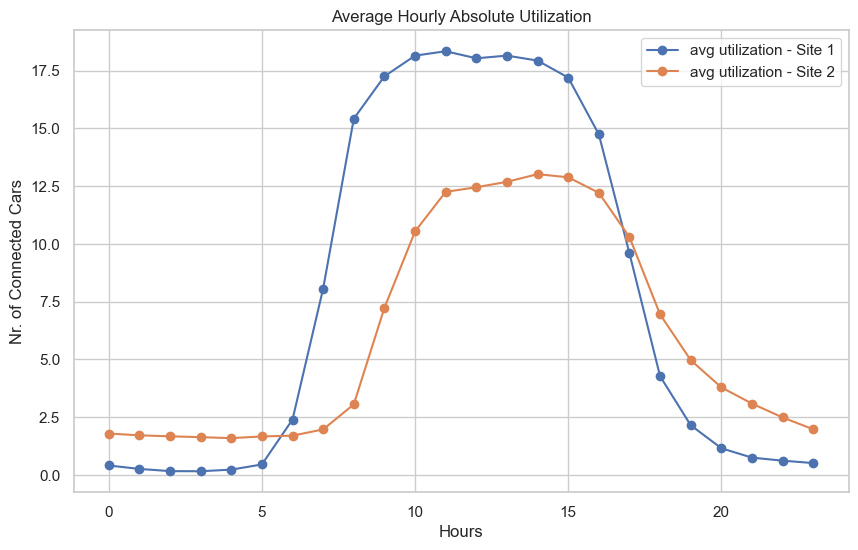

In [43]:
plot_avg_hourly_kpi(dfPlotKPI['hours'], dfPlotKPI['avgUtilization1'], 'avg utilization - Site 1', dfPlotKPI['avgUtilization2'], 'avg utilization - Site 2', 'Average Hourly Absolute Utilization', 'Nr. of Connected Cars')


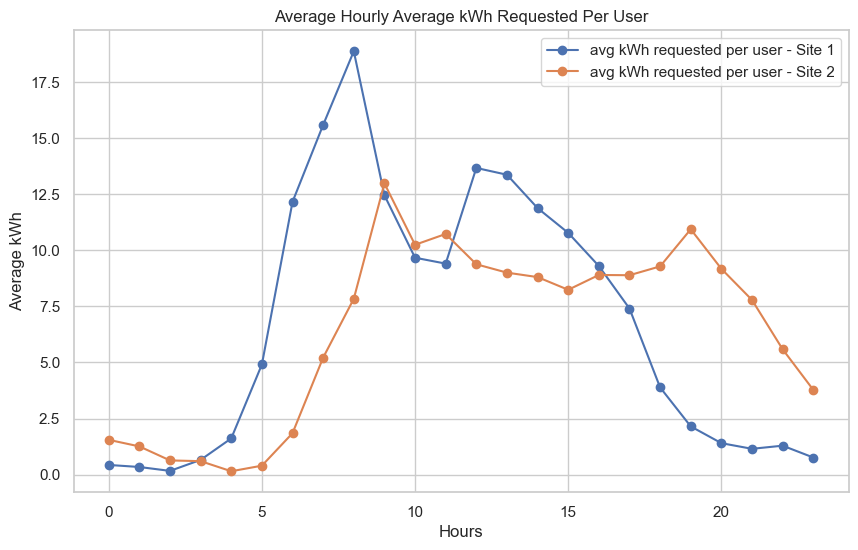

In [44]:
plot_avg_hourly_kpi(dfPlotKPI['hours'], dfPlotKPI['avg_kWhRequestedPerUser1'], 'avg kWh requested per user - Site 1', dfPlotKPI['avg_kWhRequestedPerUser2'], 'avg kWh requested per user - Site 2', 'Average Hourly Average kWh Requested Per User', 'Average kWh')


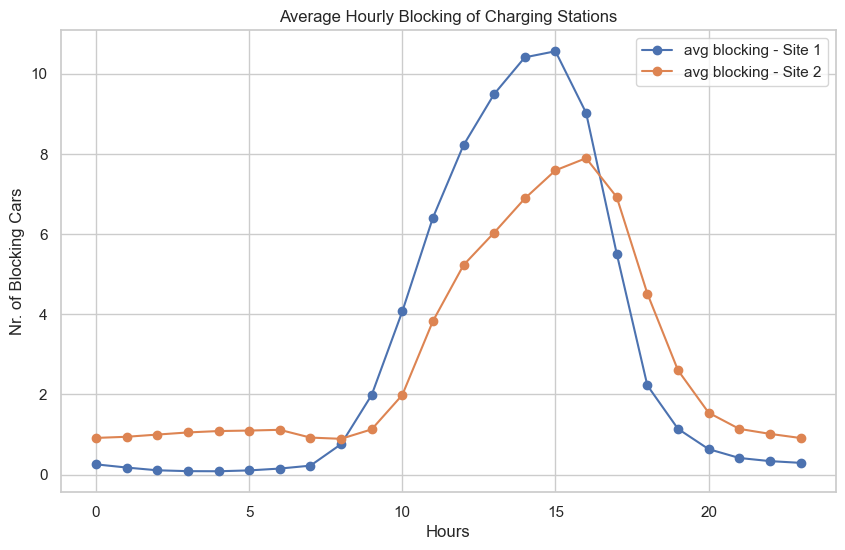

In [45]:
plot_avg_hourly_kpi(dfPlotKPI['hours'], dfPlotKPI['avgBlocking1'], 'avg blocking - Site 1', dfPlotKPI['avgBlocking2'], 'avg blocking - Site 2', 'Average Hourly Blocking of Charging Stations', 'Nr. of Blocking Cars')


## c) Site Characteristics:

Check the number of charging sessions per day belonging to each site.

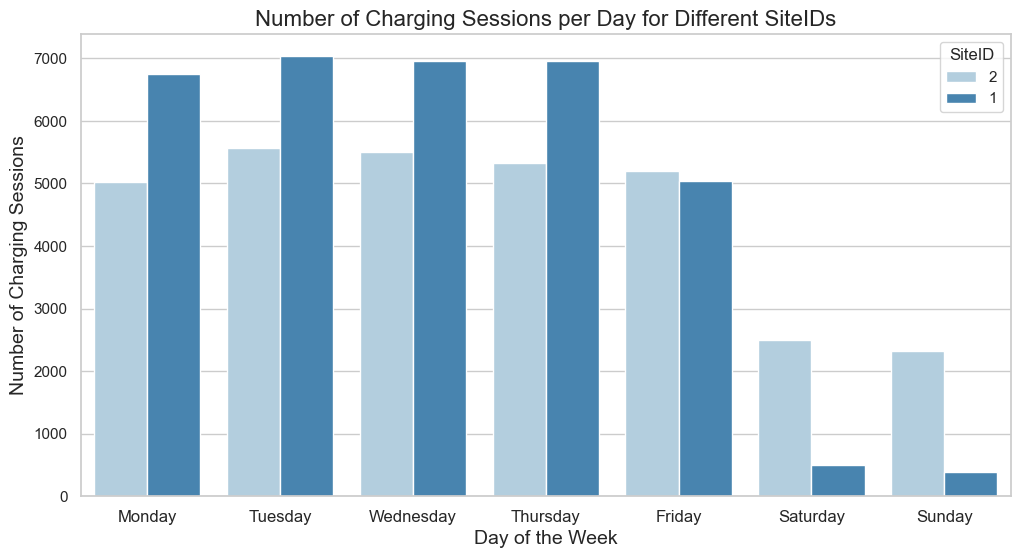

In [46]:
dfCharging['siteID'] = dfCharging['siteID'].astype('str')
plt.figure(figsize=(12, 6))
sns.countplot(x='day_of_week', hue='siteID', data=dfCharging, palette="Blues")
plt.title('Number of Charging Sessions per Day for Different SiteIDs', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=12)
plt.ylabel('Number of Charging Sessions', fontsize=14)
plt.legend(title='SiteID')
plt.show()

Interestingly, even though site 1 is used more often in general, site 2 has a much higher demand on the weekends.

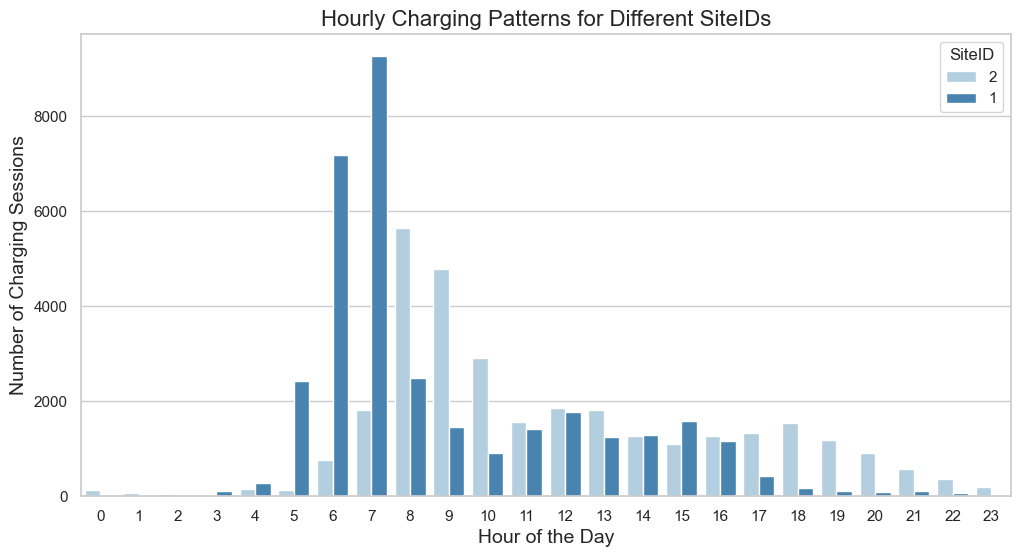

In [47]:
plt.figure(figsize=(12, 6))
sns.countplot(x='hour_of_day', hue='siteID', data=dfCharging, palette="Blues")
plt.title('Hourly Charging Patterns for Different SiteIDs', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Number of Charging Sessions', fontsize=14)
plt.legend(title='SiteID')
plt.show()

Another important point could be to check for the number of registered/unregistered users at each site.

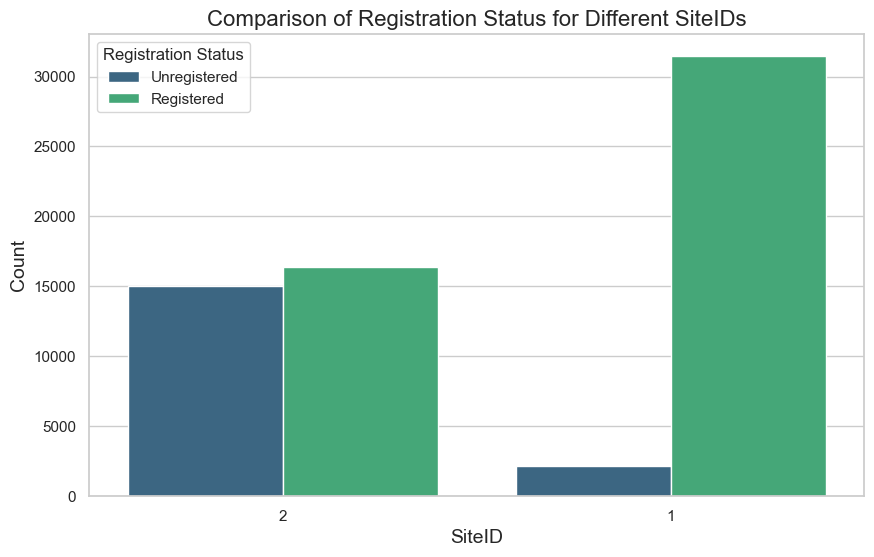

In [48]:
# Create a new column indicating registration status
dfCharging['registration_status'] = dfCharging['userID'].notnull().map({True: 'Registered', False: 'Unregistered'})

plt.figure(figsize=(10, 6))
sns.countplot(x='siteID', hue='registration_status', data=dfCharging, palette='viridis')
plt.title('Comparison of Registration Status for Different SiteIDs', fontsize=16)
plt.xlabel('SiteID', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Registration Status')
plt.show()

In site 1 there a mainly registered users.

Lets look at the average chargins session duration per site:

In [49]:
dfCharging['siteID'] = dfCharging['siteID'].astype('int')
# Calculate the duration for each charging session
dfCharging['sessionDuration'] = dfCharging['disconnectTime'] - dfCharging['connectionTime']
print('Average session duration Site 1: ' + str(dfCharging[dfCharging["siteID"] == 1]["sessionDuration"].mean()))
print('Average session duration Site 2: ' + str(dfCharging[dfCharging["siteID"] == 2]["sessionDuration"].mean()))

Average session duration Site 1: 0 days 06:51:22.665526777
Average session duration Site 2: 0 days 05:39:11.600292919


##### From these insights we can definitely say, that site 1 is the private one of the company and site 2 is the public one:
- Site 1 has mainly registered users, so supposably the people working at the company that regulary charge their vehicles there. Site 2 has almost equally registered and unregistered, which could be explained by people working or studying at the university and charging their vehicles on a regular basis on the one hand, and people that utilize it occasionally or spontaneously and hence are probably not registered on the other hand.
- Also the daily starting time of the charging session indicate that site 1 is the company. 
- As well as the weekly distribution of the charging sessions. During the working days site 1 is more utilized than site 2. On weekends its inverted. This also implies that site 2 is the public one belonging to the university.

# 3. Cluster Analysis:

In the cluster analysis we want to understand what typical charging sessions look like. To do this, one first needs to think about, how charging sessions can be characterized:
- Amount of energy delivered
- Length of the charging session
- When did the session take place (weekend/working days, daytime)
- What kind of vehicle is charged (efficiency: 'WhPerMile')
- Current weather situation (temperature, precipitation)

Additionally - Planning data of the charging session:
- Estimated parking time
- Requested kWh

According to these characteristics, charging sessions could be categorised into archetypes. So lets construct our dataframe for that:

In [50]:
#Keep relevant features from the charging dataset
dfClusteringAll = dfCharging[['connectionTime','disconnectTime','kWhDelivered','kWhRequested','WhPerMile','minutesAvailable','sessionDuration','day_of_week','hour_of_day']].copy()


#adjust the features 
#sessionDuration in minutes
dfClusteringAll['sessionDuration'] = dfClusteringAll['sessionDuration'].dt.total_seconds()/60

dfClusteringAll['arrivalOnWeekday'] = dfClusteringAll['day_of_week'] < 5
dfClusteringAll['arrivalOnWeekday'] = dfClusteringAll['arrivalOnWeekday'].astype(int)
dfClusteringAll = dfClusteringAll.drop('day_of_week',axis=1)

dfClusteringAll['arrivalMorning'] = (dfClusteringAll['hour_of_day'] >= 5) & (dfClusteringAll['hour_of_day'] <= 11)
dfClusteringAll['arrivalMorning'] = dfClusteringAll['arrivalMorning'].astype(int)
dfClusteringAll = dfClusteringAll.drop('hour_of_day',axis=1)


Now we have the relevant charging features. Note that some are only available for registered users with user inputs. This requires separate analysis. Keep connectionTime and disconnectTime for now, to add weather data.

Temperature and precipitation could influence the user behavior. Since each charging session represents a period, calculate average values of the weather features for each charging session:

In [51]:
def get_mean_weather_values(entry):
    
    series = dfWeather[(dfWeather['timestamp'] >= entry['connectionTime']) & (dfWeather['timestamp'] <= entry['disconnectTime'])]

    return series['temperature'].mean(), series['precipitation'].mean()

dfClusteringAll = pd.concat([dfClusteringAll, pd.DataFrame((dfClusteringAll.apply(lambda row: get_mean_weather_values(row), axis=1).to_list()), columns=['meanTemp','meanPrecip'])], axis=1)

dfClusteringAll = dfClusteringAll.drop('connectionTime',axis=1)
dfClusteringAll = dfClusteringAll.drop('disconnectTime',axis=1)


In [52]:
dfClusteringAll.head()

kWhDelivered  kWhRequested  WhPerMile  minutesAvailable  \
30793         7.932           NaN        NaN               NaN   
30794        10.013           NaN        NaN               NaN   
30795         5.257           NaN        NaN               NaN   
30796         5.177           NaN        NaN               NaN   
30797        10.119           NaN        NaN               NaN   

       sessionDuration  arrivalOnWeekday  arrivalMorning   meanTemp  \
30793       132.100000                 1               0  17.500000   
30794       671.100000                 1               1  17.545455   
30795       558.916667                 1               1  16.000000   
30796       558.466667                 1               1  17.500000   
30797       502.633333                 1               1  17.545455   

       meanPrecip  
30793         0.0  
30794         0.0  
30795         0.0  
30796         0.0  
30797         0.0

In the whole analysis we only focus on relevant relationships and wont consider for example relationships between only the weather features, since it doesnt tell us anything about the charging sessions.

**Let's first take a look at the features and their relationships to each other without the 'userInputs'.**

Here color the points according to arrival on weekday or weekend:

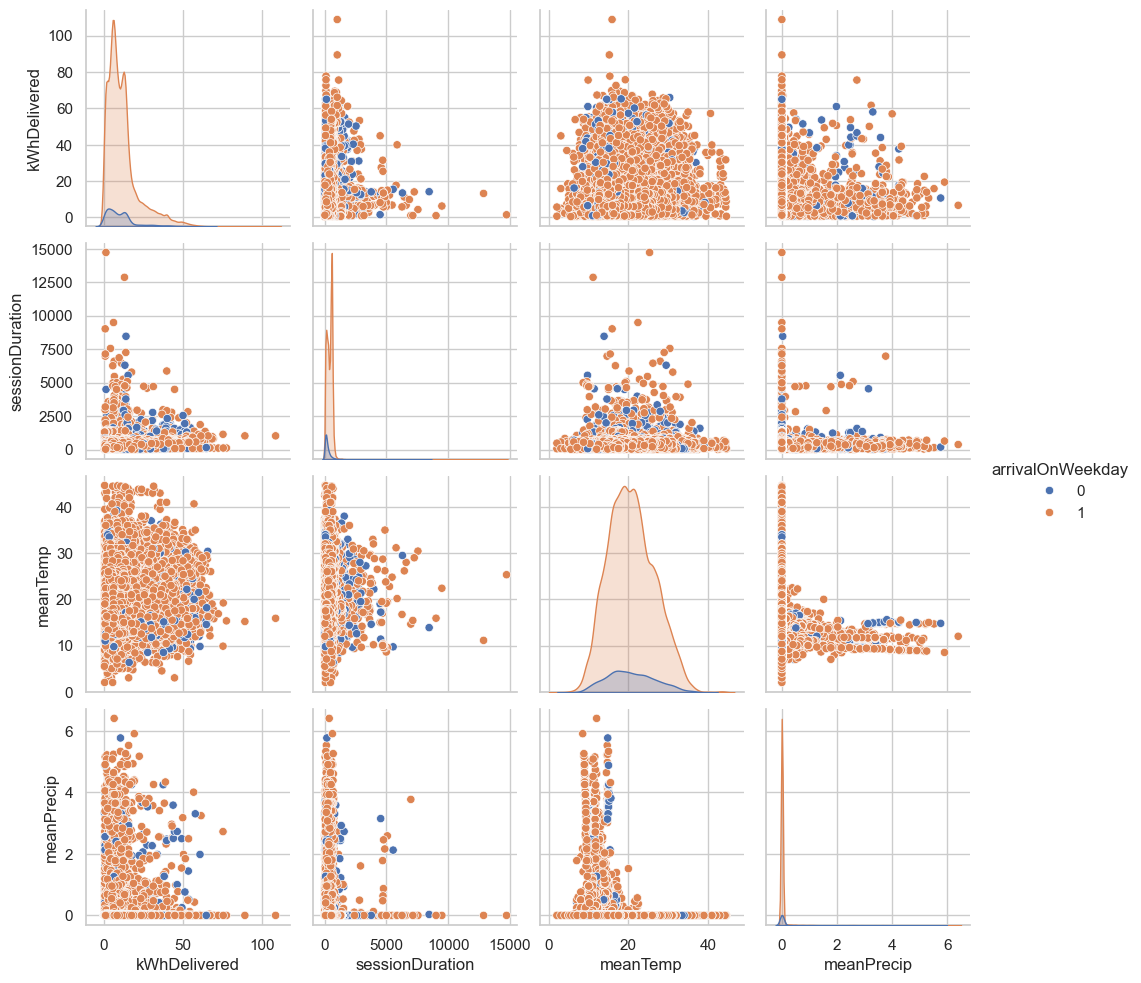

In [53]:
sns.pairplot(data=dfClusteringAll[['kWhDelivered','sessionDuration', 'meanTemp', 'meanPrecip', 'arrivalOnWeekday']], hue="arrivalOnWeekday")


The coloring according to arrivalOnWeekday does not show any significant patterns.

The relation between sessionDuration and kWhDelivered looks interesting, long sessions only with less kWhDelivered values, and no extreme long sessions with high kWhDelivered.

The relationship of sessionDuration and kWhDelivered with meanTemp looks more like the distribution of meanTemp itself, so there seems to be no significant correlation.

The relation between kWhDelivered and meanPrecip also looks meaningful with tendentially either low precipitation and up to high kWhDelivered values or high precipitation and rather lower kWhDelivered values. But this could also be explained by the lack of observations with higher precipitation:

In [54]:
print('Nr of observations with mean precip > 2: ' + str(dfClusteringAll[dfClusteringAll['meanPrecip'] > 2].shape[0]))
print('Nr of observations with mean precip <= 2: ' + str(dfClusteringAll[dfClusteringAll['meanPrecip'] <= 2].shape[0]))

Nr of observations with mean precip > 2: 446
Nr of observations with mean precip <= 2: 54375


The coloring according to arrival in the morning or not does also show no significant patterns:

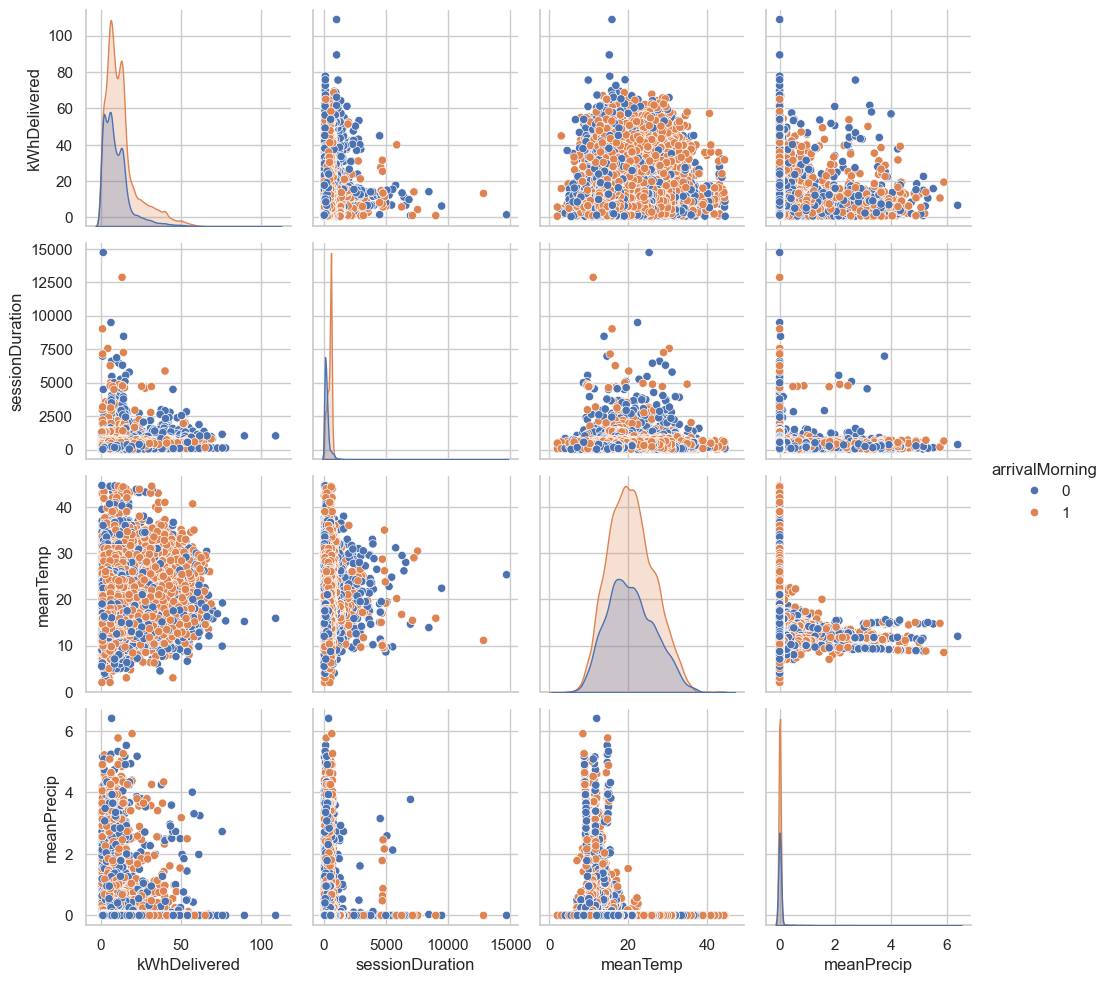

In [55]:
sns.pairplot(data=dfClusteringAll[['kWhDelivered','sessionDuration', 'meanTemp', 'meanPrecip', 'arrivalMorning']], hue="arrivalMorning")


**So here we only fix the features sessionDuration and kWhDelivered.**

**Now take a look at the features and their relationships to each other only with 'userInputs'.**

Here color the points according to arrival on weekday or weekend:

In [56]:
#Keep only rows with user inputs and exclude some outliers
dfClusteringUserInputs = dfClusteringAll[(dfClusteringAll['kWhRequested'].notnull()) & (dfClusteringAll['kWhRequested'] < 150) & (dfClusteringAll['WhPerMile'] < 1000) & (dfClusteringAll['minutesAvailable'] < 5000)]


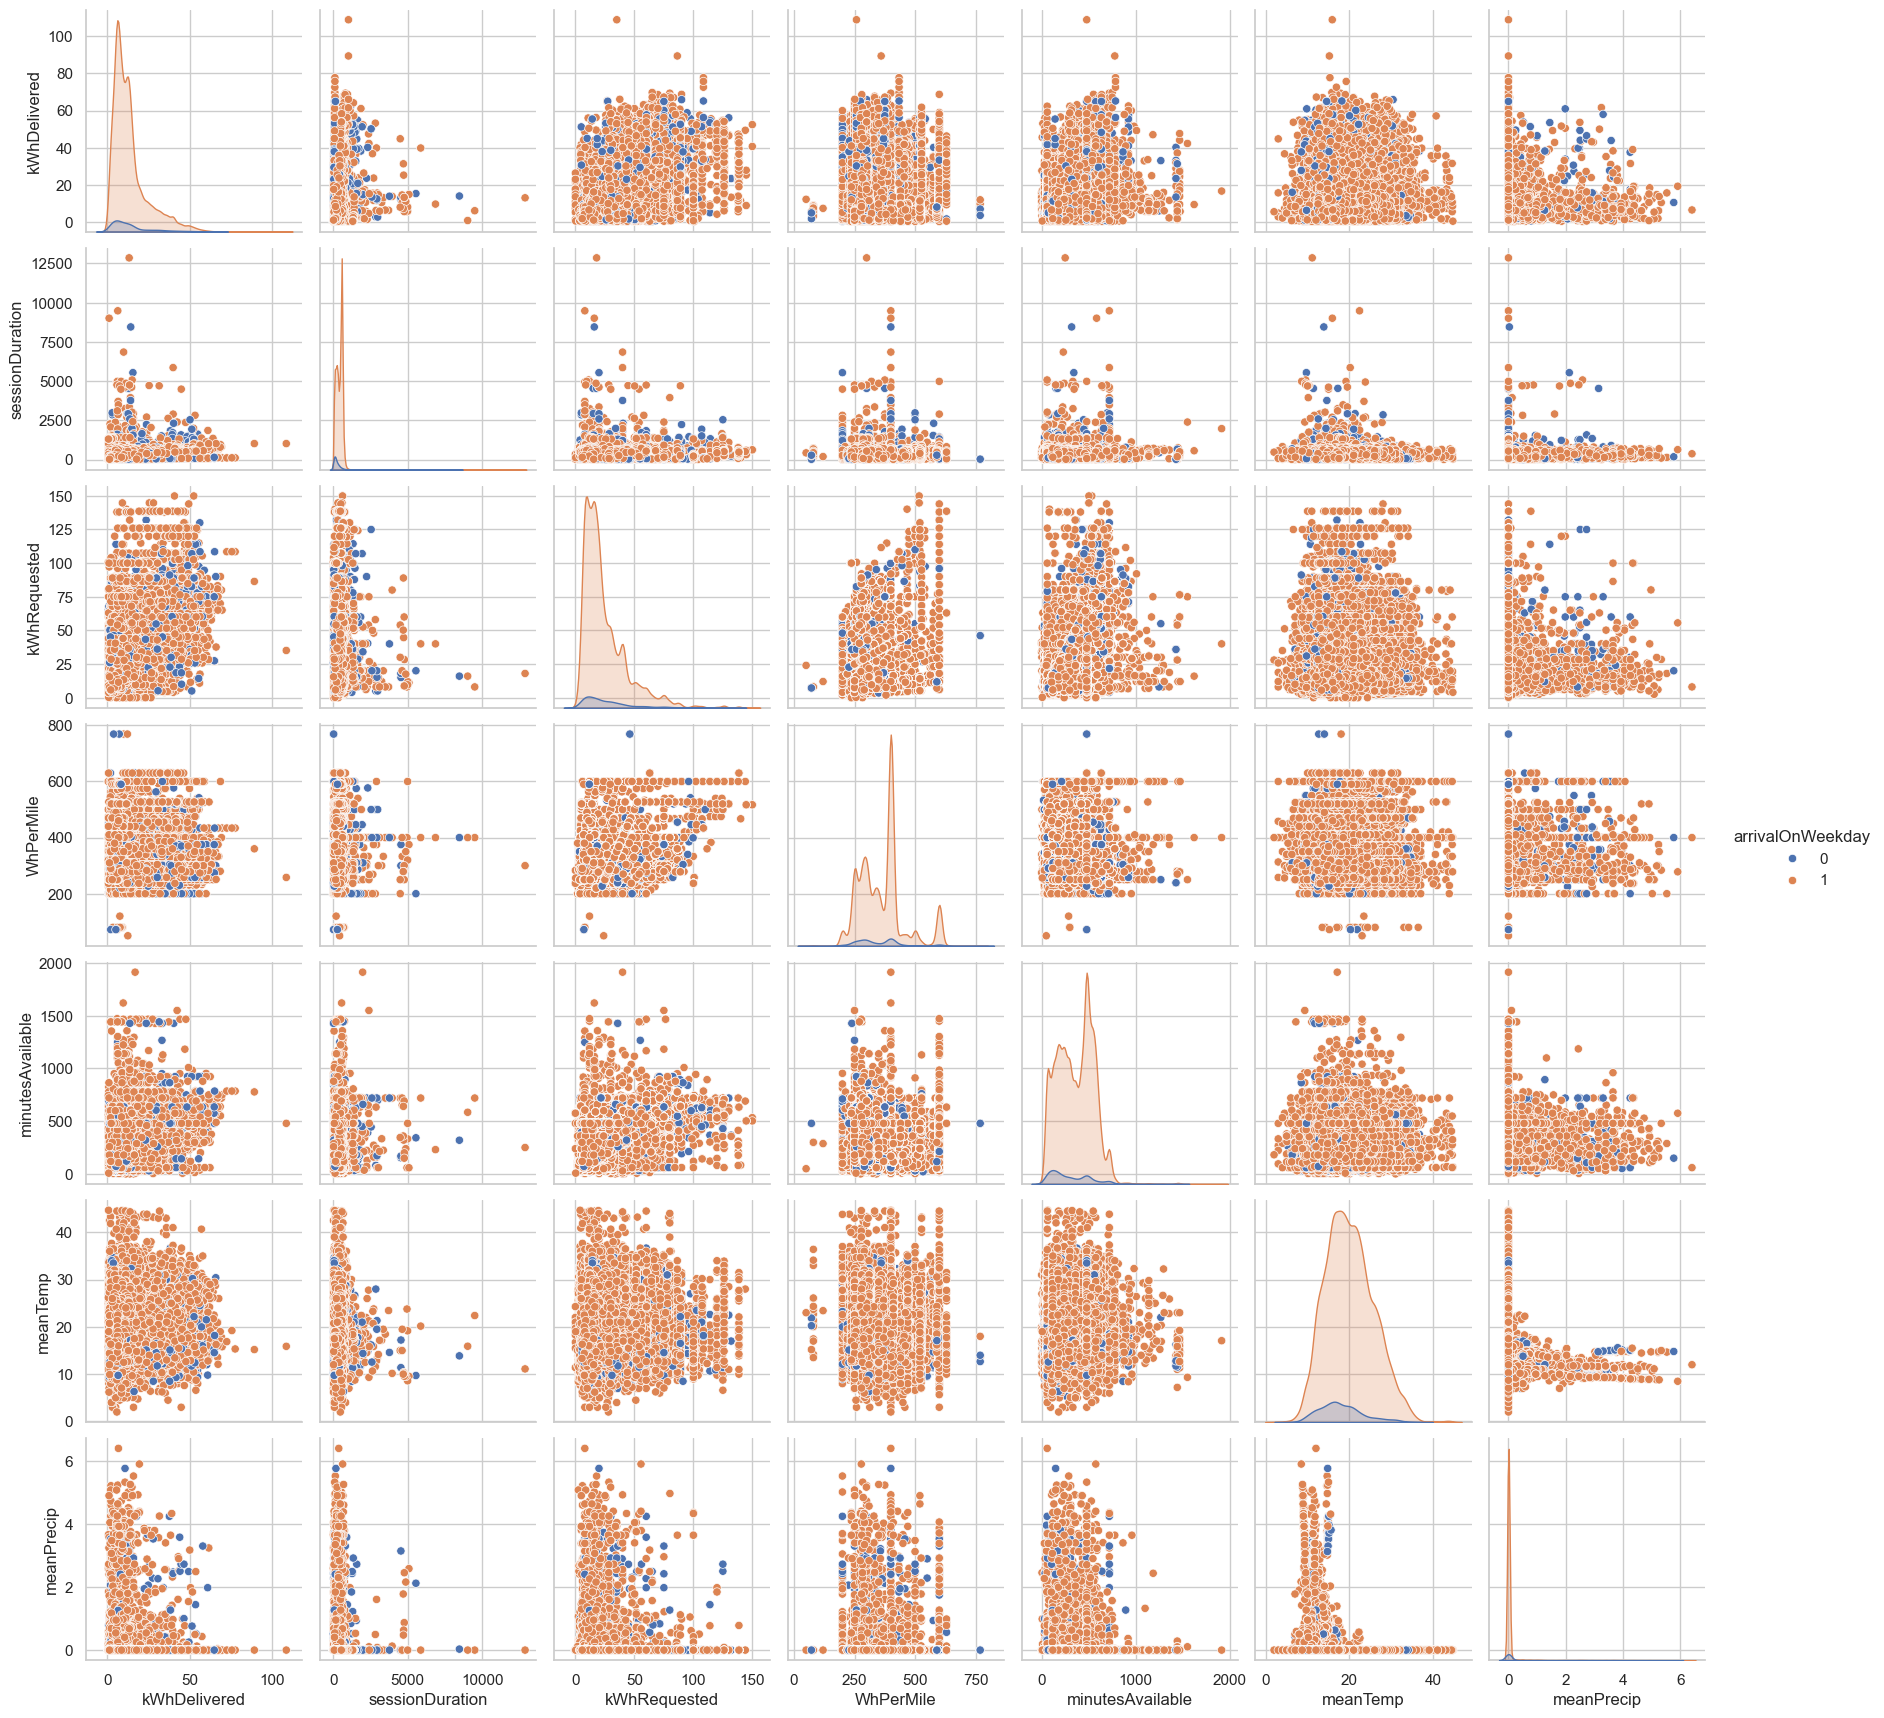

In [57]:
sns.pairplot(data=dfClusteringUserInputs[['kWhDelivered','sessionDuration','kWhRequested','WhPerMile','minutesAvailable', 'meanTemp', 'meanPrecip', 'arrivalOnWeekday']], hue="arrivalOnWeekday")


Here color the points according to arrival in the morning or not:


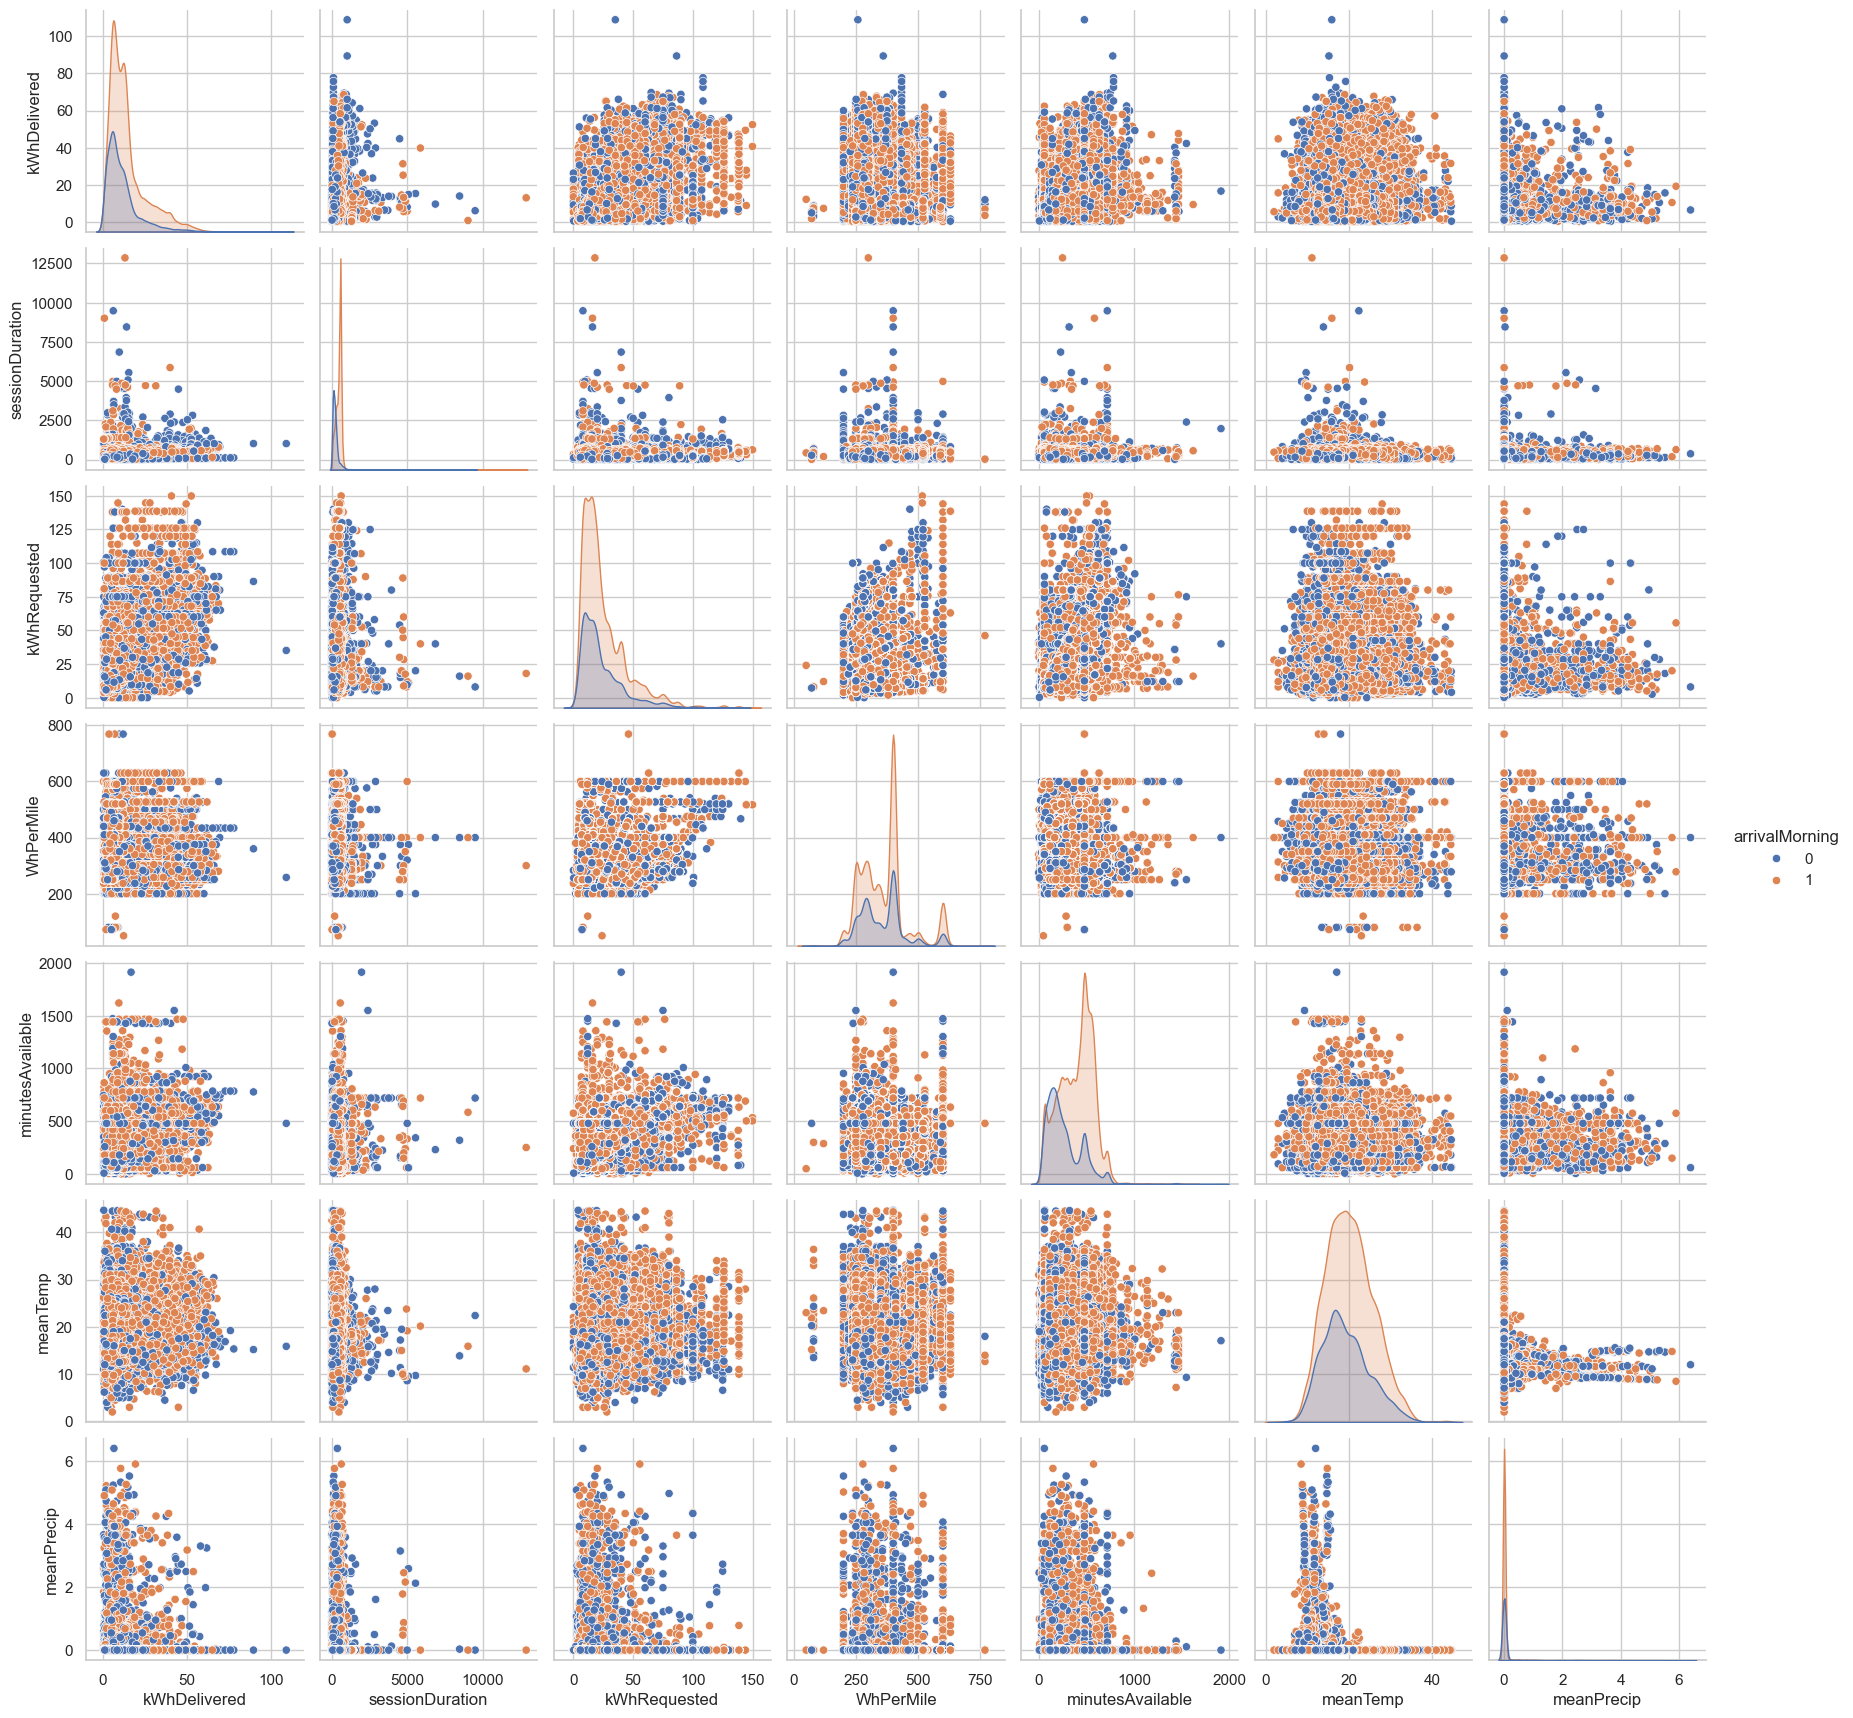

In [58]:
sns.pairplot(data=dfClusteringUserInputs[['kWhDelivered','sessionDuration','kWhRequested','WhPerMile','minutesAvailable', 'meanTemp', 'meanPrecip', 'arrivalMorning']], hue="arrivalMorning")


Here we observe that the three additional features from the userInputs don't add significant information regarding the clustering to our two focus features sessionDuration and kWhDelivered. Most of the time the distribution between the features is just one big cluster or more or less equally distributed with some points that stand out, which is mostly explained by the distribution of the feature values itself. 

Also the relationship between sessionDuration and kWhDelivered doesnt look that meaningful anymore if we exclude observations without userInput features. 

**So in order to maintain explainability and significance, lets choose to only focus on these two features:**

In [59]:
#get the relevant features
X = dfClusteringAll[['sessionDuration','kWhDelivered']].copy()

In [60]:
#exclude some outliers
X = X[(X['sessionDuration'] <= 10000) & (X['kWhDelivered'] <= 80)]

In [61]:
#scale the features
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head()

sessionDuration  kWhDelivered
30793        -0.859962     -0.370073
30794         1.039818     -0.167395
30795         0.644412     -0.630604
30796         0.642826     -0.638395
30797         0.446034     -0.157072

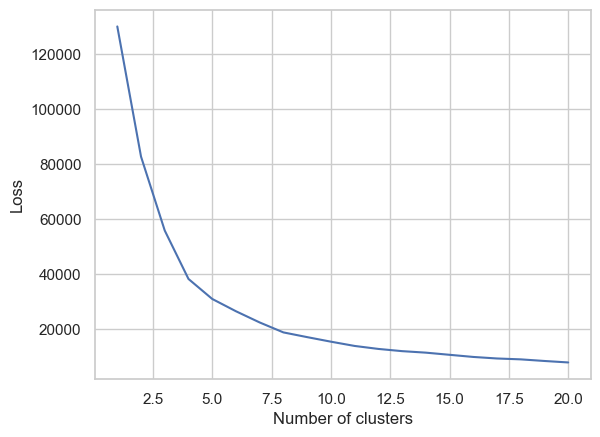

In [62]:
#dot the clustering and plot the loss
k_max = 20  
clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1, n_init='auto')
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)



plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

(0.0, 15.0)

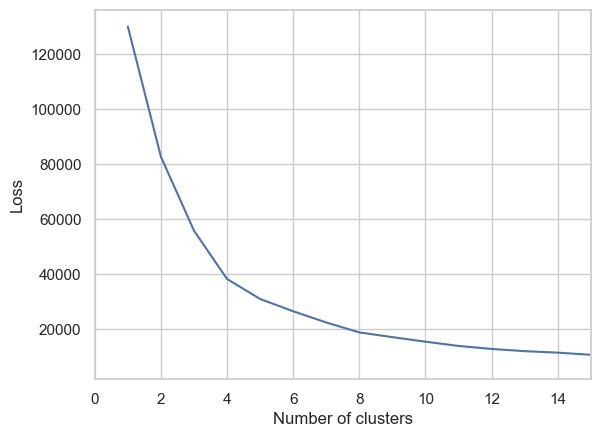

In [63]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,15])

According to the 'elbow'-method, 4 clusters seems like a reasonable number of clusters. 

<Axes: xlabel='kWhDelivered', ylabel='sessionDuration'>

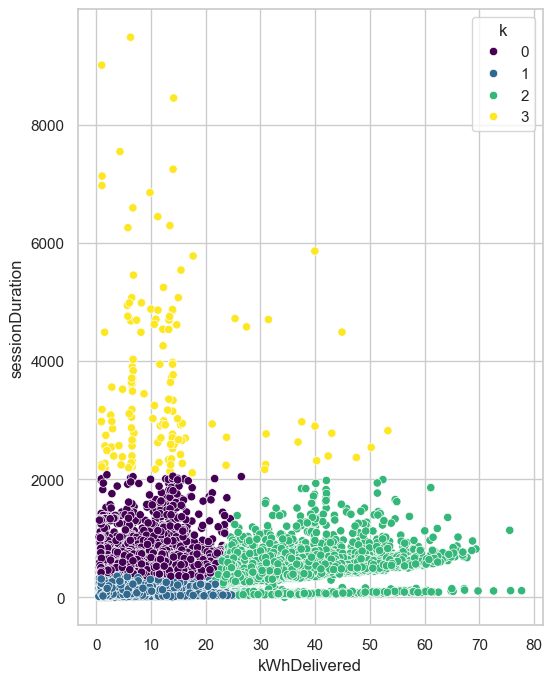

In [64]:
# refit algorithm
k_means = KMeans(n_clusters=4, n_init='auto')
k_means.fit(X_scaled)

# match records to clusters by calling predict
k_means.predict(X_scaled)

X['k'] = k_means.predict(X_scaled)

plt.figure(figsize=(6, 8))
sns.scatterplot(data=X, x='kWhDelivered', y='sessionDuration', hue='k', palette='viridis')

**Note that re-running k-means might produce different results, such that the 4 identified charging session archetypes wont make sense anymore. Check the report for the correct answer.**

**The four different charging session types could be named like this:**

- **0 - The Working Person:** Mostly stays between 8 and 10 hours and charges the EV at the place of employment (Company or University). Probably has the possibility to also charge at home, this could explain the lower amounts of energy, compared to The Fullcharger:

In [65]:
X[X['k']==0].describe()

sessionDuration  kWhDelivered        k
count     27012.000000  27012.000000  27012.0
mean        552.877325      9.793294      0.0
std         135.573050      5.028345      0.0
min         304.216667      0.506000      0.0
25%         480.366667      5.884750      0.0
50%         548.508333      9.582500      0.0
75%         599.995833     13.567000      0.0
max        2076.233333     26.513000      0.0

- **1 - The Fullcharger:** Charges high amounts of energy, is prepared to accept a certain longer service life for this, but it is also clearly limited. Could be an employee (company or university) or student who has not the possibility to charge the EV at home:

In [66]:
X[X['k']==1].describe()

sessionDuration  kWhDelivered        k
count     29632.000000  29632.000000  29632.0
mean        168.151322      7.353804      1.0
std          94.905067      5.082329      0.0
min           2.066667      0.501000      1.0
25%          88.495833      3.179750      1.0
50%         159.375000      6.385500      1.0
75%         243.737500     10.960250      1.0
max         397.916667     25.108000      1.0

- **2 - The Long-Stay Parker:** Primarily needs a parking space for more than 35h and gratefully accepts that it can also be charged there:

In [67]:
X[X['k']==2].describe()

sessionDuration  kWhDelivered       k
count      8240.000000   8240.000000  8240.0
mean        485.036598     33.812842     2.0
std         198.243119      9.239079     0.0
min           2.550000     21.091000     2.0
25%         352.245833     26.322250     2.0
50%         513.108333     31.779500     2.0
75%         583.550000     39.685000     2.0
max        1994.600000     77.700000     2.0

- **3 - The Pit-Stopper:** Is only there for the charging and just has time for a quick charging stop and tries to charges as much as possible in that short time. The amount of energy charged is cleary restricted by the short charging time:

In [68]:
X[X['k']==3].describe()

sessionDuration  kWhDelivered      k
count       149.000000    149.000000  149.0
mean       3653.055257     12.670369    3.0
std        1480.511974     10.754358    0.0
min        2108.616667      0.896000    3.0
25%        2589.950000      6.419000    3.0
50%        3086.433333     11.257000    3.0
75%        4580.750000     14.033000    3.0
max        9484.966667     53.282000    3.0

The value of identifying different types of charging sessions is to get a better understanding of the different users and behaviours, which is the basis for offering customised support services. In addition, further investigations into the individual types of charging sessions can be carried out in order to increase and optimise the overall supply, availability and performance. 

# 4. Utilization Predicition

We now want to predict the hourly utilization of the two sites. We have considered that utilization could be the number of connected cars or the amount of energy consumed. This would allow us to predict on the one hand how many spaces should be available and an the other hand how much energy the operator should provide. 
We choosed the first possibility to predict the utilization.  
So in the following we want to predict the hourly number of connected cars for each of the two sites. So this means how many parking slots are occupied.

## 4.1. Data Preparation for Prediction

In [69]:
dfMerged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65037 entries, 0 to 65036
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype                              
---  ------                   --------------  -----                              
 0   id                       65037 non-null  object                             
 1   connectionTime           65037 non-null  datetime64[ns, America/Los_Angeles]
 2   disconnectTime           65037 non-null  datetime64[ns, America/Los_Angeles]
 3   doneChargingTime         60950 non-null  datetime64[ns, America/Los_Angeles]
 4   kWhDelivered             65037 non-null  float64                            
 5   sessionID                65037 non-null  object                             
 6   siteID                   65037 non-null  int64                              
 7   spaceID                  65037 non-null  object                             
 8   stationID                65037 non-null  object                   

**For our predictions we don't need all of the given columns so we first remove the columns we obviously don't need for the predictions:**

In [70]:
print(dfMerged["timezone"].unique())

['America/Los_Angeles']


In [71]:
print(dfMerged["city"].unique())

['Burbank' nan]


Because all rows have the same entry in the column "timezone" and "city" we can drop this column

In [72]:
#remove columns we don't need for our predictions
dfMerged = dfMerged.drop('id', axis=1)
dfMerged = dfMerged.drop('doneChargingTime', axis=1)
dfMerged = dfMerged.drop('kWhDelivered', axis=1)
dfMerged = dfMerged.drop('sessionID', axis=1)
dfMerged = dfMerged.drop('spaceID', axis=1)
dfMerged = dfMerged.drop('stationID', axis=1)
dfMerged = dfMerged.drop('timezone', axis=1)
dfMerged = dfMerged.drop('userID', axis=1)
dfMerged = dfMerged.drop('WhPerMile', axis=1)
dfMerged = dfMerged.drop('kWhRequested', axis=1)
dfMerged = dfMerged.drop('milesRequested', axis=1)
dfMerged = dfMerged.drop('minutesAvailable', axis=1)
dfMerged = dfMerged.drop('modifiedAt', axis=1)
dfMerged = dfMerged.drop('paymentRequired', axis=1)
dfMerged = dfMerged.drop('requestedDeparture', axis=1)
dfMerged = dfMerged.drop('city', axis=1)
dfMerged = dfMerged.drop('timestamp', axis=1) #because it was merged to connectiontime
dfMerged = dfMerged.drop('cloud_cover_description', axis=1) #because we already have the cloud_cover in the data

dfMerged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65037 entries, 0 to 65036
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype                              
---  ------            --------------  -----                              
 0   connectionTime    65037 non-null  datetime64[ns, America/Los_Angeles]
 1   disconnectTime    65037 non-null  datetime64[ns, America/Los_Angeles]
 2   siteID            65037 non-null  int64                              
 3   temperature       56024 non-null  float64                            
 4   cloud_cover       56024 non-null  float64                            
 5   pressure          56024 non-null  float64                            
 6   windspeed         56024 non-null  float64                            
 7   precipitation     56024 non-null  float64                            
 8   felt_temperature  56024 non-null  float64                            
dtypes: datetime64[ns, America/Los_Angeles](2), float64(6), int64(1

As we need the weather data for the prediction, we delete all rows with zero values

In [73]:
#delete all rows with null-values
dfMerged = dfMerged.dropna()
dfMerged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56024 entries, 0 to 56126
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype                              
---  ------            --------------  -----                              
 0   connectionTime    56024 non-null  datetime64[ns, America/Los_Angeles]
 1   disconnectTime    56024 non-null  datetime64[ns, America/Los_Angeles]
 2   siteID            56024 non-null  int64                              
 3   temperature       56024 non-null  float64                            
 4   cloud_cover       56024 non-null  float64                            
 5   pressure          56024 non-null  float64                            
 6   windspeed         56024 non-null  float64                            
 7   precipitation     56024 non-null  float64                            
 8   felt_temperature  56024 non-null  float64                            
dtypes: datetime64[ns, America/Los_Angeles](2), float64(6), int64(1)
mem

From one row in the dataset create multiple rows for every hour the respective car of the row was connected. We have to do this, so we can calculate the number of connected cars during the different hours.

In [74]:
dfMerged.head()

connectionTime            disconnectTime  siteID  temperature  \
0 2018-04-25 04:08:04-07:00 2018-04-25 06:20:10-07:00       2         12.0   
1 2018-04-25 06:45:10-07:00 2018-04-25 17:56:16-07:00       2         12.0   
2 2018-04-25 06:45:50-07:00 2018-04-25 16:04:45-07:00       2         12.0   
3 2018-04-25 07:37:06-07:00 2018-04-25 16:55:34-07:00       2         12.0   
4 2018-04-25 07:40:34-07:00 2018-04-25 16:03:12-07:00       2         12.0   

   cloud_cover  pressure  windspeed  precipitation  felt_temperature  
0         26.0    989.11       11.0            0.0              12.0  
1         20.0    989.44        9.0            0.0              12.0  
2         20.0    989.44        9.0            0.0              12.0  
3         20.0    989.44        7.0            0.0              12.0  
4         20.0    989.44        7.0            0.0              12.0

In [75]:
dfMerged['connectionTime'] = pd.DatetimeIndex(dfMerged['connectionTime']).floor('H')
dfMerged['disconnectTime'] = pd.DatetimeIndex(dfMerged['disconnectTime']).floor('H')
dfMerged

connectionTime            disconnectTime  siteID  \
0     2018-04-25 04:00:00-07:00 2018-04-25 06:00:00-07:00       2   
1     2018-04-25 06:00:00-07:00 2018-04-25 17:00:00-07:00       2   
2     2018-04-25 06:00:00-07:00 2018-04-25 16:00:00-07:00       2   
3     2018-04-25 07:00:00-07:00 2018-04-25 16:00:00-07:00       2   
4     2018-04-25 07:00:00-07:00 2018-04-25 16:00:00-07:00       2   
...                         ...                       ...     ...   
56122 2020-12-30 19:00:00-08:00 2020-12-30 22:00:00-08:00       1   
56123 2020-12-31 08:00:00-08:00 2020-12-31 09:00:00-08:00       2   
56124 2020-12-31 08:00:00-08:00 2020-12-31 09:00:00-08:00       2   
56125 2020-12-31 09:00:00-08:00 2020-12-31 10:00:00-08:00       2   
56126 2020-12-31 10:00:00-08:00 2020-12-31 13:00:00-08:00       1   

       temperature  cloud_cover  pressure  windspeed  precipitation  \
0             12.0         26.0    989.11       11.0            0.0   
1             12.0         20.0    989.44        9.0            0.0   
2             12.0         20.0    989.44        9.0            0.0   
3             12.0         20.0    989.44        7.0            0.0   
4             12.0         20.0    989.44        7.0            0.0   
...            ...          ...       ...        ...            ...   
56122         13.0         33.0    992.41        6.0            0.0   
56123          6.0         34.0    987.14        0.0            0.0   
56124          6.0         34.0    987.14        0.0            0.0   
56125         13.0         34.0    987.14       19.0            0.0   
56126         13.0         34.0    986.81       22.0            0.0   

       felt_temperature  
0                  12.0  
1                  12.0  
2                  12.0  
3                  12.0  
4                  12.0  
...                 ...  
56122              13.0  
56123               6.0  
56124               6.0  
56125              13.0  
56126              13.0  

[56024 rows x 9 columns]

In [76]:
from datetime import timedelta

# Create a function to generate rows for each hour
def generate_rows(row):
    start = row['connectionTime']
    end = row['disconnectTime']
    time_diff = end - start  # Calculate the time difference
    hours_diff = int(time_diff.total_seconds() // 3600)

    # Generate new rows
    new_rows = pd.DataFrame({
        'Hour': [start + timedelta(hours=i) for i in range(hours_diff + 1)],
    })

    # Repeat the additional information for each generated row
    for col in dfMerged.columns:
        new_rows[col] = row[col]
    
    return new_rows

# Apply the function to each row and concatenate the results
dfPrediction1 = pd.concat(dfMerged.apply(generate_rows, axis=1).tolist(), ignore_index=True)

# Drop unnecessary columns
dfPrediction1 = dfPrediction1.drop(columns=['connectionTime', 'disconnectTime'])

dfPrediction1

Hour  siteID  temperature  cloud_cover  pressure  \
0      2018-04-25 04:00:00-07:00       2         12.0         26.0    989.11   
1      2018-04-25 05:00:00-07:00       2         12.0         26.0    989.11   
2      2018-04-25 06:00:00-07:00       2         12.0         26.0    989.11   
3      2018-04-25 06:00:00-07:00       2         12.0         20.0    989.44   
4      2018-04-25 07:00:00-07:00       2         12.0         20.0    989.44   
...                          ...     ...          ...          ...       ...   
419358 2020-12-31 10:00:00-08:00       2         13.0         34.0    987.14   
419359 2020-12-31 10:00:00-08:00       1         13.0         34.0    986.81   
419360 2020-12-31 11:00:00-08:00       1         13.0         34.0    986.81   
419361 2020-12-31 12:00:00-08:00       1         13.0         34.0    986.81   
419362 2020-12-31 13:00:00-08:00       1         13.0         34.0    986.81   

        windspeed  precipitation  felt_temperature  
0            11.0            0.0              12.0  
1            11.0            0.0              12.0  
2            11.0            0.0              12.0  
3             9.0            0.0              12.0  
4             9.0            0.0              12.0  
...           ...            ...               ...  
419358       19.0            0.0              13.0  
419359       22.0            0.0              13.0  
419360       22.0            0.0              13.0  
419361       22.0            0.0              13.0  
419362       22.0            0.0              13.0  

[419363 rows x 8 columns]

In [77]:
#Split the Hour column in date and hour
dfPrediction1['date'] = dfPrediction1['Hour'].dt.date
dfPrediction1['date'] = pd.to_datetime(dfPrediction1['date'])
dfPrediction1['hour'] = dfPrediction1['Hour'].dt.hour
dfPrediction1 = dfPrediction1.drop('Hour', axis=1)
dfPrediction1

siteID  temperature  cloud_cover  pressure  windspeed  precipitation  \
0            2         12.0         26.0    989.11       11.0            0.0   
1            2         12.0         26.0    989.11       11.0            0.0   
2            2         12.0         26.0    989.11       11.0            0.0   
3            2         12.0         20.0    989.44        9.0            0.0   
4            2         12.0         20.0    989.44        9.0            0.0   
...        ...          ...          ...       ...        ...            ...   
419358       2         13.0         34.0    987.14       19.0            0.0   
419359       1         13.0         34.0    986.81       22.0            0.0   
419360       1         13.0         34.0    986.81       22.0            0.0   
419361       1         13.0         34.0    986.81       22.0            0.0   
419362       1         13.0         34.0    986.81       22.0            0.0   

        felt_temperature       date  hour  
0                   12.0 2018-04-25     4  
1                   12.0 2018-04-25     5  
2                   12.0 2018-04-25     6  
3                   12.0 2018-04-25     6  
4                   12.0 2018-04-25     7  
...                  ...        ...   ...  
419358              13.0 2020-12-31    10  
419359              13.0 2020-12-31    10  
419360              13.0 2020-12-31    11  
419361              13.0 2020-12-31    12  
419362              13.0 2020-12-31    13  

[419363 rows x 9 columns]

In [78]:
dfPrediction1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419363 entries, 0 to 419362
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   siteID            419363 non-null  int64         
 1   temperature       419363 non-null  float64       
 2   cloud_cover       419363 non-null  float64       
 3   pressure          419363 non-null  float64       
 4   windspeed         419363 non-null  float64       
 5   precipitation     419363 non-null  float64       
 6   felt_temperature  419363 non-null  float64       
 7   date              419363 non-null  datetime64[ns]
 8   hour              419363 non-null  int32         
dtypes: datetime64[ns](1), float64(6), int32(1), int64(1)
memory usage: 27.2 MB


In [79]:
#put the new columns to the beginning
dfPrediction1 = dfPrediction1[['date', 'hour', 'siteID', 'temperature',
                               'cloud_cover', 'pressure', 
                               'windspeed', 'precipitation', 'felt_temperature']]
dfPrediction1

date  hour  siteID  temperature  cloud_cover  pressure  \
0      2018-04-25     4       2         12.0         26.0    989.11   
1      2018-04-25     5       2         12.0         26.0    989.11   
2      2018-04-25     6       2         12.0         26.0    989.11   
3      2018-04-25     6       2         12.0         20.0    989.44   
4      2018-04-25     7       2         12.0         20.0    989.44   
...           ...   ...     ...          ...          ...       ...   
419358 2020-12-31    10       2         13.0         34.0    987.14   
419359 2020-12-31    10       1         13.0         34.0    986.81   
419360 2020-12-31    11       1         13.0         34.0    986.81   
419361 2020-12-31    12       1         13.0         34.0    986.81   
419362 2020-12-31    13       1         13.0         34.0    986.81   

        windspeed  precipitation  felt_temperature  
0            11.0            0.0              12.0  
1            11.0            0.0              12.0  
2            11.0            0.0              12.0  
3             9.0            0.0              12.0  
4             9.0            0.0              12.0  
...           ...            ...               ...  
419358       19.0            0.0              13.0  
419359       22.0            0.0              13.0  
419360       22.0            0.0              13.0  
419361       22.0            0.0              13.0  
419362       22.0            0.0              13.0  

[419363 rows x 9 columns]

**Adding new features:**

Show number of parked cars per hour:

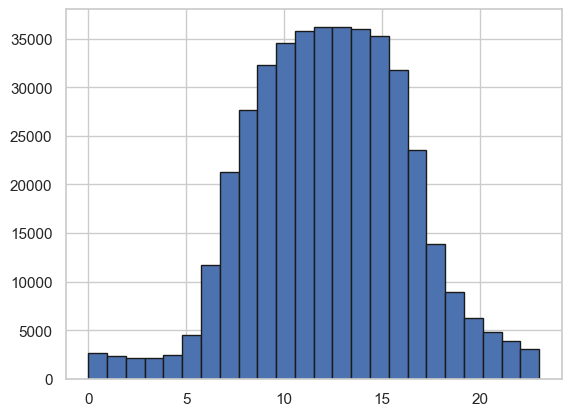

In [80]:
# show the number of parked cars per hour
data = dfPrediction1['hour']
plt.hist(data, bins = 24, edgecolor='k')
plt.show()

The graphic shows a clear difference between the different times of day. For this reason, we create a feature that indicates the respective time of day. We divide the day into 07:00 to 10:00 morning, 11:00 to 12:00 late morning, 13:00 to 14:00 noon, 15:00 to 17:00 afternoon, 18:00 to 21:00 evening and 22:00 to 06:00 night.

We will also look at some other additional features. In the following is a list of all features.

Features we want to look at:
- hour
- temperature
- cloud_cover
- pressure
- windspeed
- precipitation
- felt_temperature
- timeOfDay
- dayOfWeek
- isWeekend
- season

The features hour, temperature, cloud_cover, pressure, windspeed, precipitation and felt_temperature are already included in the dataset. We now need to add the columns timeOfDay, dayOfWeek, isWeekend and season.

- timeOfDay gives back an integer value between 0 and 6 (0=morning, ..., 5=night)
- dayOfWeek gives back an integer value between 0 and 6 (0=Monday, ... ,6=Sunday)
- isWeekend gives back 0 when its a weekday, and 1 when it ison weekend
- season gives back an integer value between 1 and 4 ( 1=winter, 2=spring, 3=summer, 4=fall)

In [81]:
#Add column timeOfDay
def timeOfDay(hour):
    if hour >= 7 and hour <= 10:
        return 0
    elif hour >= 11 and hour <= 12:
        return 1
    elif hour >= 13 and hour <= 14:
        return 2
    elif hour >= 15 and hour <= 17: 
        return 3
    elif hour >= 18 and hour <= 21: 
        return 4
    else:
        return 5

dfPrediction1.loc[:,'timeOfDay'] = dfPrediction1.loc[:,'hour'].map(timeOfDay)
dfPrediction1.head()

C:\Users\Caroline\AppData\Local\Temp\ipykernel_111420\2289713767.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfPrediction1.loc[:,'timeOfDay'] = dfPrediction1.loc[:,'hour'].map(timeOfDay)


date  hour  siteID  temperature  cloud_cover  pressure  windspeed  \
0 2018-04-25     4       2         12.0         26.0    989.11       11.0   
1 2018-04-25     5       2         12.0         26.0    989.11       11.0   
2 2018-04-25     6       2         12.0         26.0    989.11       11.0   
3 2018-04-25     6       2         12.0         20.0    989.44        9.0   
4 2018-04-25     7       2         12.0         20.0    989.44        9.0   

   precipitation  felt_temperature  timeOfDay  
0            0.0              12.0          5  
1            0.0              12.0          5  
2            0.0              12.0          5  
3            0.0              12.0          5  
4            0.0              12.0          0

In [82]:
#Add columne dayOfWeek
dfPrediction1.loc[:,'dayOfWeek'] = dfPrediction1.loc[:,'date'].dt.weekday
dfPrediction1.head()

C:\Users\Caroline\AppData\Local\Temp\ipykernel_111420\1079915129.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfPrediction1.loc[:,'dayOfWeek'] = dfPrediction1.loc[:,'date'].dt.weekday


date  hour  siteID  temperature  cloud_cover  pressure  windspeed  \
0 2018-04-25     4       2         12.0         26.0    989.11       11.0   
1 2018-04-25     5       2         12.0         26.0    989.11       11.0   
2 2018-04-25     6       2         12.0         26.0    989.11       11.0   
3 2018-04-25     6       2         12.0         20.0    989.44        9.0   
4 2018-04-25     7       2         12.0         20.0    989.44        9.0   

   precipitation  felt_temperature  timeOfDay  dayOfWeek  
0            0.0              12.0          5          2  
1            0.0              12.0          5          2  
2            0.0              12.0          5          2  
3            0.0              12.0          5          2  
4            0.0              12.0          0          2

In [83]:
#Add column IsWeekend
def isWeekend(dayOfWeek):
    if dayOfWeek >= 5:
        return 1
    else:
        return 0
        
dfPrediction1.loc[:,'isWeekend'] = dfPrediction1.loc[:,'dayOfWeek'].map(isWeekend)
dfPrediction1.head()

C:\Users\Caroline\AppData\Local\Temp\ipykernel_111420\3821986705.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfPrediction1.loc[:,'isWeekend'] = dfPrediction1.loc[:,'dayOfWeek'].map(isWeekend)


date  hour  siteID  temperature  cloud_cover  pressure  windspeed  \
0 2018-04-25     4       2         12.0         26.0    989.11       11.0   
1 2018-04-25     5       2         12.0         26.0    989.11       11.0   
2 2018-04-25     6       2         12.0         26.0    989.11       11.0   
3 2018-04-25     6       2         12.0         20.0    989.44        9.0   
4 2018-04-25     7       2         12.0         20.0    989.44        9.0   

   precipitation  felt_temperature  timeOfDay  dayOfWeek  isWeekend  
0            0.0              12.0          5          2          0  
1            0.0              12.0          5          2          0  
2            0.0              12.0          5          2          0  
3            0.0              12.0          5          2          0  
4            0.0              12.0          0          2          0

In [84]:
# add season feature
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = {}
for k in range(1, 13):
    month_to_season[k]= seasons[k-1]
month_to_season
# 1= winter , 2= spring , 3= summer , 4= fall

dfPrediction1 = dfPrediction1.assign(season=lambda x: x["date"].apply(lambda s: month_to_season[s.month]))
dfPrediction1.head()

date  hour  siteID  temperature  cloud_cover  pressure  windspeed  \
0 2018-04-25     4       2         12.0         26.0    989.11       11.0   
1 2018-04-25     5       2         12.0         26.0    989.11       11.0   
2 2018-04-25     6       2         12.0         26.0    989.11       11.0   
3 2018-04-25     6       2         12.0         20.0    989.44        9.0   
4 2018-04-25     7       2         12.0         20.0    989.44        9.0   

   precipitation  felt_temperature  timeOfDay  dayOfWeek  isWeekend  season  
0            0.0              12.0          5          2          0       2  
1            0.0              12.0          5          2          0       2  
2            0.0              12.0          5          2          0       2  
3            0.0              12.0          5          2          0       2  
4            0.0              12.0          0          2          0       2

In [85]:
#Add the column numOfConnectedCars to the dataset, as this should be the output-variable
dfPrediction1['numberOfConnectedCars'] = 0
dfPrediction1.head()

date  hour  siteID  temperature  cloud_cover  pressure  windspeed  \
0 2018-04-25     4       2         12.0         26.0    989.11       11.0   
1 2018-04-25     5       2         12.0         26.0    989.11       11.0   
2 2018-04-25     6       2         12.0         26.0    989.11       11.0   
3 2018-04-25     6       2         12.0         20.0    989.44        9.0   
4 2018-04-25     7       2         12.0         20.0    989.44        9.0   

   precipitation  felt_temperature  timeOfDay  dayOfWeek  isWeekend  season  \
0            0.0              12.0          5          2          0       2   
1            0.0              12.0          5          2          0       2   
2            0.0              12.0          5          2          0       2   
3            0.0              12.0          5          2          0       2   
4            0.0              12.0          0          2          0       2   

   numberOfConnectedCars  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0

### 4.1.1. Preparation for site 1:

In [86]:
#filter the data for the site with id 1
dfPrediction1Site1 = dfPrediction1.loc[dfPrediction1['siteID'] == 1]
dfPrediction1Site1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222715 entries, 59442 to 419362
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   222715 non-null  datetime64[ns]
 1   hour                   222715 non-null  int32         
 2   siteID                 222715 non-null  int64         
 3   temperature            222715 non-null  float64       
 4   cloud_cover            222715 non-null  float64       
 5   pressure               222715 non-null  float64       
 6   windspeed              222715 non-null  float64       
 7   precipitation          222715 non-null  float64       
 8   felt_temperature       222715 non-null  float64       
 9   timeOfDay              222715 non-null  int64         
 10  dayOfWeek              222715 non-null  int32         
 11  isWeekend              222715 non-null  int64         
 12  season                 222715 non-null  int64

**Group dataframe by date and hour:**

In [87]:
#Group the dfPrediction1Site1 dataset by date and hour and count the connections per group by showing the line numberOfConnectedCars
dfNumberOfConnectedCarsGrouped = dfPrediction1Site1.groupby(["date", "hour"])['numberOfConnectedCars'].count().reset_index()

In [88]:
dfNumberOfConnectedCarsGrouped 

date  hour  numberOfConnectedCars
0     2018-09-05     4                      2
1     2018-09-05     5                      4
2     2018-09-05     6                     11
3     2018-09-05     7                     16
4     2018-09-05     8                     15
...          ...   ...                    ...
11947 2020-12-30    22                      1
11948 2020-12-31    10                      1
11949 2020-12-31    11                      1
11950 2020-12-31    12                      1
11951 2020-12-31    13                      1

[11952 rows x 3 columns]

In [89]:
#drop the column numberOfConnectedCars and siteID in the dfPrediction1Site1 dataset
dfPrediction1Site1 = dfPrediction1Site1.drop('numberOfConnectedCars', axis=1)
dfPrediction1Site1 = dfPrediction1Site1.drop('siteID', axis=1)
dfPrediction1Site1

date  hour  temperature  cloud_cover  pressure  windspeed  \
59442  2018-09-05     4         19.0         26.0    984.50        0.0   
59443  2018-09-05     5         19.0         26.0    984.50        0.0   
59444  2018-09-05     6         19.0         26.0    984.50        0.0   
59445  2018-09-05     7         19.0         26.0    984.50        0.0   
59446  2018-09-05     8         19.0         26.0    984.50        0.0   
...           ...   ...          ...          ...       ...        ...   
419352 2020-12-30    22         13.0         33.0    992.41        6.0   
419359 2020-12-31    10         13.0         34.0    986.81       22.0   
419360 2020-12-31    11         13.0         34.0    986.81       22.0   
419361 2020-12-31    12         13.0         34.0    986.81       22.0   
419362 2020-12-31    13         13.0         34.0    986.81       22.0   

        precipitation  felt_temperature  timeOfDay  dayOfWeek  isWeekend  \
59442             0.0              19.0          5          2          0   
59443             0.0              19.0          5          2          0   
59444             0.0              19.0          5          2          0   
59445             0.0              19.0          0          2          0   
59446             0.0              19.0          0          2          0   
...               ...               ...        ...        ...        ...   
419352            0.0              13.0          5          2          0   
419359            0.0              13.0          0          3          0   
419360            0.0              13.0          1          3          0   
419361            0.0              13.0          1          3          0   
419362            0.0              13.0          2          3          0   

        season  
59442        4  
59443        4  
59444        4  
59445        4  
59446        4  
...        ...  
419352       1  
419359       1  
419360       1  
419361       1  
419362       1  

[222715 rows x 12 columns]

In [90]:
# merge the grouped dataset with the numberOfConnectedCars per group with the dfPrediction1Site1 dataset, to add the other features per group
dfTest = pd.merge(dfNumberOfConnectedCarsGrouped, dfPrediction1Site1, on =['date','hour'], how = 'left')
dfTest

date  hour  numberOfConnectedCars  temperature  cloud_cover  \
0      2018-09-05     4                      2         19.0         26.0   
1      2018-09-05     4                      2         19.0         26.0   
2      2018-09-05     5                      4         19.0         26.0   
3      2018-09-05     5                      4         19.0         26.0   
4      2018-09-05     5                      4         19.0         26.0   
...           ...   ...                    ...          ...          ...   
222710 2020-12-30    22                      1         13.0         33.0   
222711 2020-12-31    10                      1         13.0         34.0   
222712 2020-12-31    11                      1         13.0         34.0   
222713 2020-12-31    12                      1         13.0         34.0   
222714 2020-12-31    13                      1         13.0         34.0   

        pressure  windspeed  precipitation  felt_temperature  timeOfDay  \
0         984.50        0.0            0.0              19.0          5   
1         984.50        0.0            0.0              19.0          5   
2         984.50        0.0            0.0              19.0          5   
3         984.50        0.0            0.0              19.0          5   
4         984.83        6.0            0.0              19.0          5   
...          ...        ...            ...               ...        ...   
222710    992.41        6.0            0.0              13.0          5   
222711    986.81       22.0            0.0              13.0          0   
222712    986.81       22.0            0.0              13.0          1   
222713    986.81       22.0            0.0              13.0          1   
222714    986.81       22.0            0.0              13.0          2   

        dayOfWeek  isWeekend  season  
0               2          0       4  
1               2          0       4  
2               2          0       4  
3               2          0       4  
4               2          0       4  
...           ...        ...     ...  
222710          2          0       1  
222711          3          0       1  
222712          3          0       1  
222713          3          0       1  
222714          3          0       1  

[222715 rows x 13 columns]

In [91]:
dfTestdropped = dfTest.drop_duplicates()
dfTestdropped

date  hour  numberOfConnectedCars  temperature  cloud_cover  \
0      2018-09-05     4                      2         19.0         26.0   
2      2018-09-05     5                      4         19.0         26.0   
4      2018-09-05     5                      4         19.0         26.0   
6      2018-09-05     6                     11         19.0         26.0   
8      2018-09-05     6                     11         19.0         26.0   
...           ...   ...                    ...          ...          ...   
222710 2020-12-30    22                      1         13.0         33.0   
222711 2020-12-31    10                      1         13.0         34.0   
222712 2020-12-31    11                      1         13.0         34.0   
222713 2020-12-31    12                      1         13.0         34.0   
222714 2020-12-31    13                      1         13.0         34.0   

        pressure  windspeed  precipitation  felt_temperature  timeOfDay  \
0         984.50        0.0            0.0              19.0          5   
2         984.50        0.0            0.0              19.0          5   
4         984.83        6.0            0.0              19.0          5   
6         984.50        0.0            0.0              19.0          5   
8         984.83        6.0            0.0              19.0          5   
...          ...        ...            ...               ...        ...   
222710    992.41        6.0            0.0              13.0          5   
222711    986.81       22.0            0.0              13.0          0   
222712    986.81       22.0            0.0              13.0          1   
222713    986.81       22.0            0.0              13.0          1   
222714    986.81       22.0            0.0              13.0          2   

        dayOfWeek  isWeekend  season  
0               2          0       4  
2               2          0       4  
4               2          0       4  
6               2          0       4  
8               2          0       4  
...           ...        ...     ...  
222710          2          0       1  
222711          3          0       1  
222712          3          0       1  
222713          3          0       1  
222714          3          0       1  

[49424 rows x 13 columns]

In [92]:
# define a dictionary that maps features to aggreagation routines
agg_dict = {'numberOfConnectedCars':"max", 'temperature':"mean", 'cloud_cover':"max", 'pressure':"max", 'windspeed':"max", 'precipitation':"max", 'felt_temperature':"max", 'timeOfDay':"max", 'dayOfWeek':"max", 'isWeekend':"max", 'season':"max"}

In [93]:
#aggregate the dfTestdroppedGrouped dataset so we only have left as many lines as there are different date and hour combinations and these are not duplicated by different values of the other features.
dfTestdroppedGrouped = dfTestdropped.groupby(["date", "hour"]).agg(agg_dict).reset_index()
dfTestdroppedGrouped

date  hour  numberOfConnectedCars  temperature  cloud_cover  \
0     2018-09-05     4                      2         19.0         26.0   
1     2018-09-05     5                      4         19.0         26.0   
2     2018-09-05     6                     11         19.0         28.0   
3     2018-09-05     7                     16         19.0         28.0   
4     2018-09-05     8                     15         19.0         28.0   
...          ...   ...                    ...          ...          ...   
11947 2020-12-30    22                      1         13.0         33.0   
11948 2020-12-31    10                      1         13.0         34.0   
11949 2020-12-31    11                      1         13.0         34.0   
11950 2020-12-31    12                      1         13.0         34.0   
11951 2020-12-31    13                      1         13.0         34.0   

       pressure  windspeed  precipitation  felt_temperature  timeOfDay  \
0        984.50        0.0            0.0              19.0          5   
1        984.83        6.0            0.0              19.0          5   
2        986.15        7.0            0.0              19.0          5   
3        986.15        7.0            0.0              19.0          0   
4        986.15        7.0            0.0              19.0          0   
...         ...        ...            ...               ...        ...   
11947    992.41        6.0            0.0              13.0          5   
11948    986.81       22.0            0.0              13.0          0   
11949    986.81       22.0            0.0              13.0          1   
11950    986.81       22.0            0.0              13.0          1   
11951    986.81       22.0            0.0              13.0          2   

       dayOfWeek  isWeekend  season  
0              2          0       4  
1              2          0       4  
2              2          0       4  
3              2          0       4  
4              2          0       4  
...          ...        ...     ...  
11947          2          0       1  
11948          3          0       1  
11949          3          0       1  
11950          3          0       1  
11951          3          0       1  

[11952 rows x 13 columns]

In [94]:
dfTestdroppedClean = dfTestdroppedGrouped.drop_duplicates()

In [95]:
#save the prepared dataframe for regression again in the variable dfPrediction1Site1
dfPrediction1Site1 = dfTestdroppedClean
dfPrediction1Site1

date  hour  numberOfConnectedCars  temperature  cloud_cover  \
0     2018-09-05     4                      2         19.0         26.0   
1     2018-09-05     5                      4         19.0         26.0   
2     2018-09-05     6                     11         19.0         28.0   
3     2018-09-05     7                     16         19.0         28.0   
4     2018-09-05     8                     15         19.0         28.0   
...          ...   ...                    ...          ...          ...   
11947 2020-12-30    22                      1         13.0         33.0   
11948 2020-12-31    10                      1         13.0         34.0   
11949 2020-12-31    11                      1         13.0         34.0   
11950 2020-12-31    12                      1         13.0         34.0   
11951 2020-12-31    13                      1         13.0         34.0   

       pressure  windspeed  precipitation  felt_temperature  timeOfDay  \
0        984.50        0.0            0.0              19.0          5   
1        984.83        6.0            0.0              19.0          5   
2        986.15        7.0            0.0              19.0          5   
3        986.15        7.0            0.0              19.0          0   
4        986.15        7.0            0.0              19.0          0   
...         ...        ...            ...               ...        ...   
11947    992.41        6.0            0.0              13.0          5   
11948    986.81       22.0            0.0              13.0          0   
11949    986.81       22.0            0.0              13.0          1   
11950    986.81       22.0            0.0              13.0          1   
11951    986.81       22.0            0.0              13.0          2   

       dayOfWeek  isWeekend  season  
0              2          0       4  
1              2          0       4  
2              2          0       4  
3              2          0       4  
4              2          0       4  
...          ...        ...     ...  
11947          2          0       1  
11948          3          0       1  
11949          3          0       1  
11950          3          0       1  
11951          3          0       1  

[11952 rows x 13 columns]

#### Feature evaluation:

Test which features should be selected for the prediction.
We now use one the Variance Criteria and the Correlation Criteria, because we only have a handful of features.

**Variance:**

In [96]:
dfPrediction1Site1[['hour', 'numberOfConnectedCars', 'temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation', 'felt_temperature', 'timeOfDay', 'dayOfWeek', 'isWeekend', 'season']].var()

hour                      33.338513
numberOfConnectedCars    443.661870
temperature               32.915541
cloud_cover               15.531201
pressure                  14.215645
windspeed                 54.559900
precipitation              0.484425
felt_temperature          41.382417
timeOfDay                  3.413766
dayOfWeek                  3.360213
isWeekend                  0.145980
season                     1.379898
dtype: float64

**Correlations:**

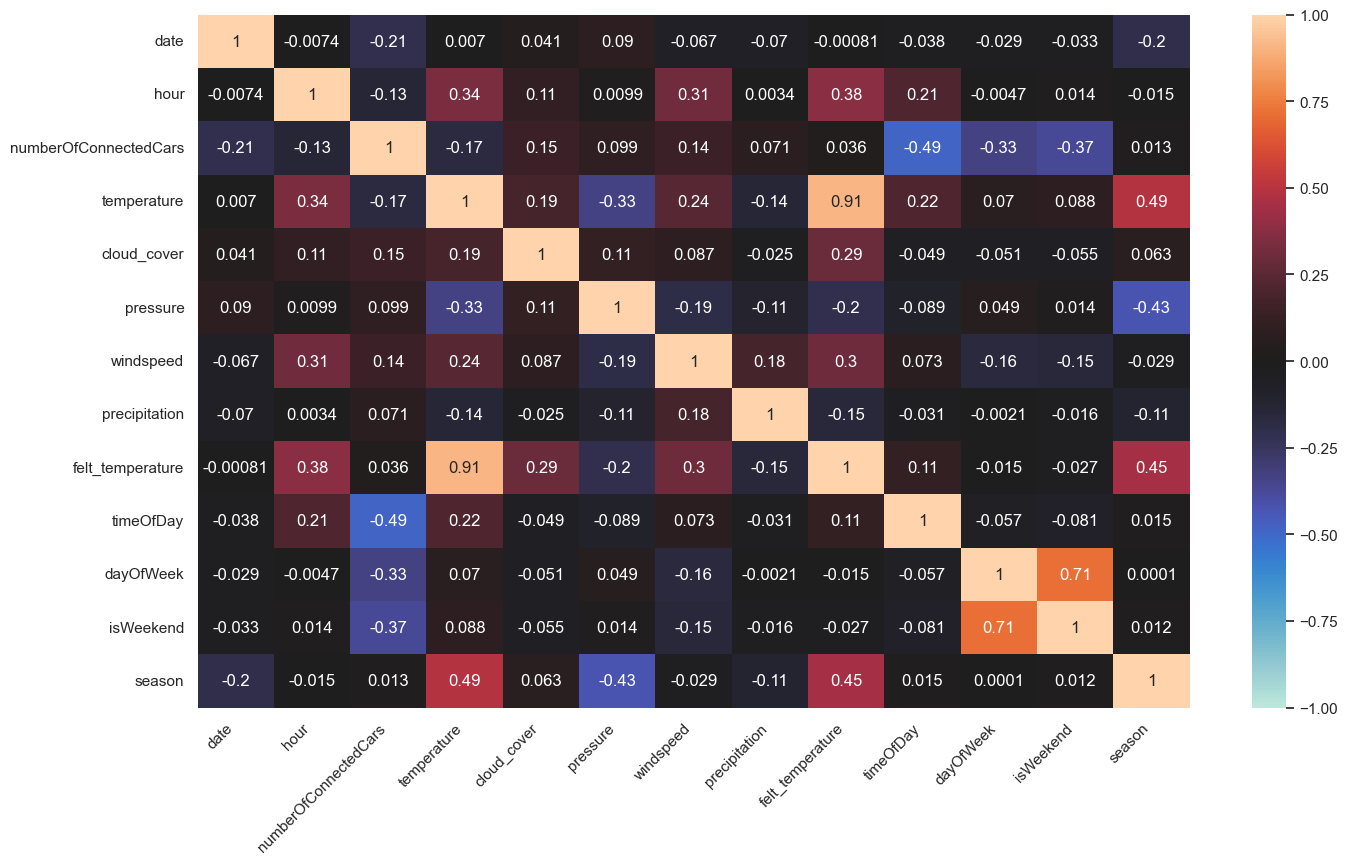

In [97]:
corrCars = dfPrediction1Site1.corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corrCars, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

As we can see, the features temperature and felt_temperature are highly correlated with each other, which is why we will eliminate the felt_temperature feature. Since we have not so much features, we will keep all of the other features for prediction.

In [98]:
#drop feature felt_temperature
dfPrediction1Site1 = dfPrediction1Site1.drop('felt_temperature', axis=1)
dfPrediction1Site1

date  hour  numberOfConnectedCars  temperature  cloud_cover  \
0     2018-09-05     4                      2         19.0         26.0   
1     2018-09-05     5                      4         19.0         26.0   
2     2018-09-05     6                     11         19.0         28.0   
3     2018-09-05     7                     16         19.0         28.0   
4     2018-09-05     8                     15         19.0         28.0   
...          ...   ...                    ...          ...          ...   
11947 2020-12-30    22                      1         13.0         33.0   
11948 2020-12-31    10                      1         13.0         34.0   
11949 2020-12-31    11                      1         13.0         34.0   
11950 2020-12-31    12                      1         13.0         34.0   
11951 2020-12-31    13                      1         13.0         34.0   

       pressure  windspeed  precipitation  timeOfDay  dayOfWeek  isWeekend  \
0        984.50        0.0            0.0          5          2          0   
1        984.83        6.0            0.0          5          2          0   
2        986.15        7.0            0.0          5          2          0   
3        986.15        7.0            0.0          0          2          0   
4        986.15        7.0            0.0          0          2          0   
...         ...        ...            ...        ...        ...        ...   
11947    992.41        6.0            0.0          5          2          0   
11948    986.81       22.0            0.0          0          3          0   
11949    986.81       22.0            0.0          1          3          0   
11950    986.81       22.0            0.0          1          3          0   
11951    986.81       22.0            0.0          2          3          0   

       season  
0           4  
1           4  
2           4  
3           4  
4           4  
...       ...  
11947       1  
11948       1  
11949       1  
11950       1  
11951       1  

[11952 rows x 12 columns]

**Visualisation of dependencies:**

In [99]:
# hour of connected cars 
df1 = dfPrediction1Site1[['hour', 'numberOfConnectedCars']].groupby('hour').mean()

#temperature
x2 = dfPrediction1Site1['temperature'].values

#min_temperature
df3 = dfPrediction1Site1[['cloud_cover', 'numberOfConnectedCars']].groupby('cloud_cover').mean()

#pressure
x4 = dfPrediction1Site1['pressure'].values

#windspeed
df5 = dfPrediction1Site1[['windspeed', 'numberOfConnectedCars']].groupby('windspeed').mean()

#precipitation
df6 = dfPrediction1Site1[['precipitation', 'numberOfConnectedCars']].groupby('precipitation').mean()

#timeOfDay
df7 = dfPrediction1Site1[['timeOfDay', 'numberOfConnectedCars']].groupby('timeOfDay').mean()

#day of Week
df8 = dfPrediction1Site1[['dayOfWeek', 'numberOfConnectedCars']].groupby('dayOfWeek').mean()

# is weekend
df9 = dfPrediction1Site1[['isWeekend', 'numberOfConnectedCars']].groupby('isWeekend').mean()

#season
df10 = dfPrediction1Site1[['season', 'numberOfConnectedCars']].groupby('season').mean()

yscatter = dfPrediction1Site1['numberOfConnectedCars'].values 

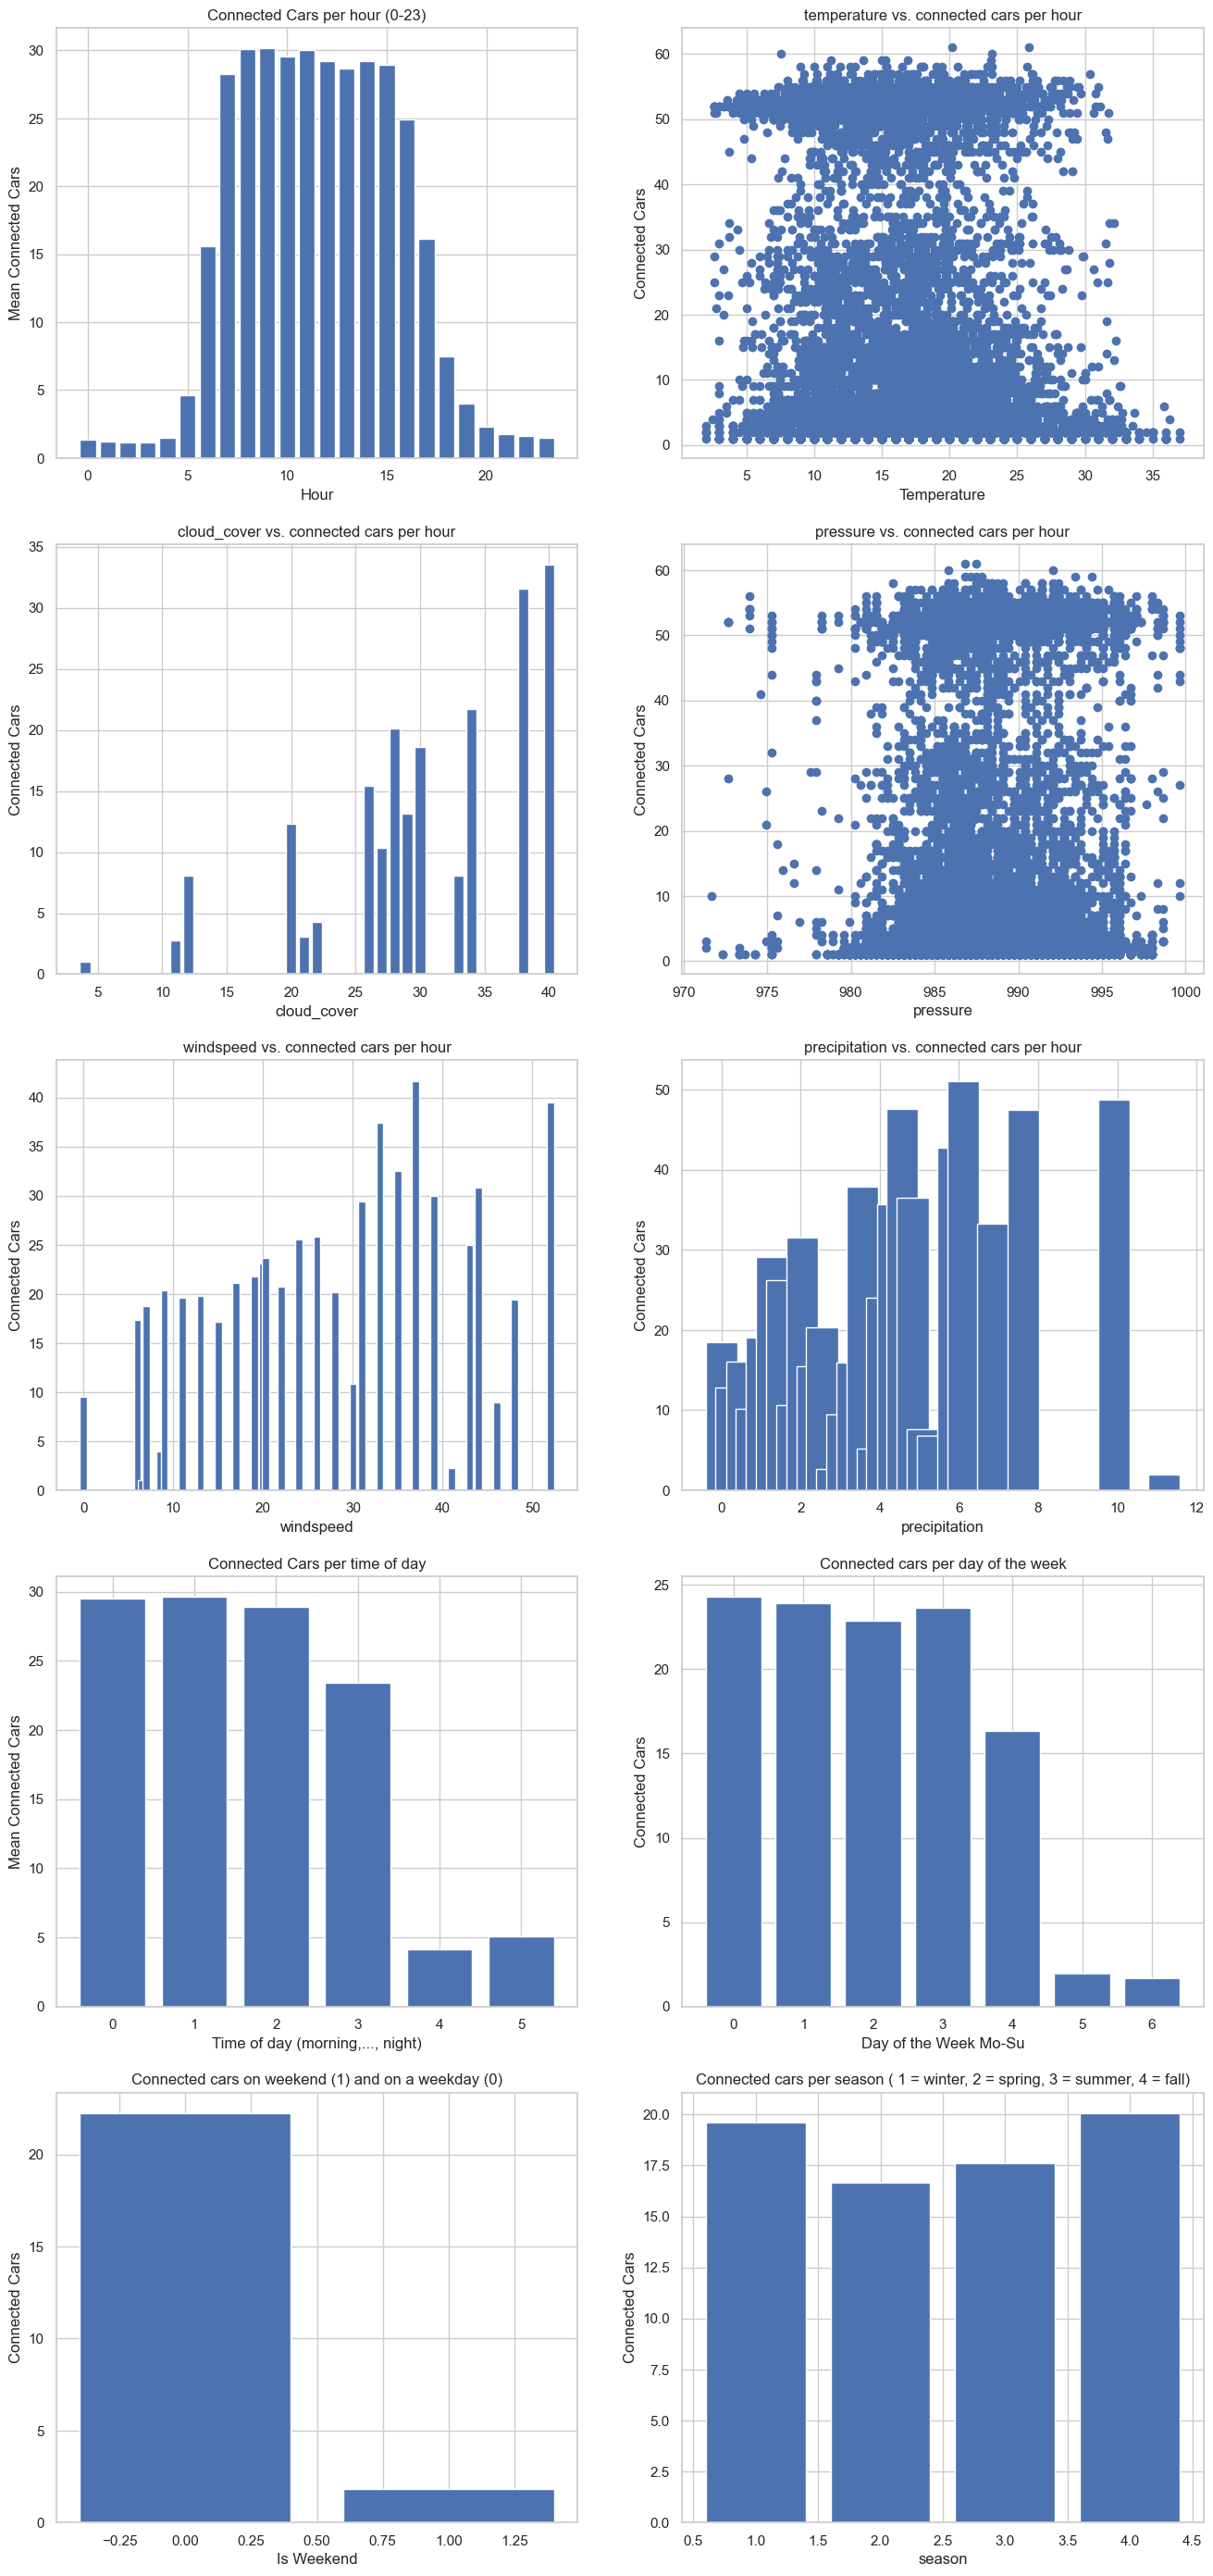

In [100]:
Fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize=(16, 35))

# subplot no. 1
plt.subplot(5,2,1)
plt.xlabel("Hour")
plt.ylabel("Mean Connected Cars")
plt.title("Connected Cars per hour (0-23)")
plt.bar(df1.index, df1["numberOfConnectedCars"])

# subplot no. 2
plt.subplot(5,2,2) 
plt.xlabel("Temperature")
plt.ylabel("Connected Cars")
plt.title("temperature vs. connected cars per hour")
plt.scatter(x2, yscatter)

# subplot no. 3
plt.subplot(5,2,3) 
plt.xlabel("cloud_cover")
plt.ylabel("Connected Cars")
plt.title("cloud_cover vs. connected cars per hour")
plt.bar(df3.index, df3["numberOfConnectedCars"])

# subplot no. 4
plt.subplot(5,2,4)
plt.xlabel("pressure")
plt.ylabel("Connected Cars")
plt.title("pressure vs. connected cars per hour")
plt.scatter(x4, yscatter)

# subplot no. 5
plt.subplot(5,2,5)
plt.xlabel("windspeed")
plt.ylabel("Connected Cars")
plt.title("windspeed vs. connected cars per hour")
plt.bar(df5.index, df5["numberOfConnectedCars"])

# subplot no. 6
plt.subplot(5,2,6)
plt.xlabel("precipitation")
plt.ylabel("Connected Cars")
plt.title("precipitation vs. connected cars per hour")
plt.bar(df6.index, df6["numberOfConnectedCars"])

# subplot no. 7
plt.subplot(5,2,7)
plt.xlabel("Time of day (morning,..., night)")
plt.ylabel("Mean Connected Cars")
plt.title("Connected Cars per time of day")
plt.bar(df7.index, df7["numberOfConnectedCars"])

# subplot no. 8
plt.subplot(5,2,8) 
plt.xlabel("Day of the Week Mo-Su")
plt.ylabel("Connected Cars")
plt.title("Connected cars per day of the week")
plt.bar(df8.index, df8["numberOfConnectedCars"])

# subplot no. 6
plt.subplot(5,2,9) 
plt.xlabel("Is Weekend")
plt.ylabel("Connected Cars")
plt.title("Connected cars on weekend (1) and on a weekday (0)")
plt.bar(df9.index, df9["numberOfConnectedCars"])

# subplot no. 7
plt.subplot(5,2,10)
plt.xlabel("season")
plt.ylabel("Connected Cars")
plt.title("Connected cars per season ( 1 = winter, 2 = spring, 3 = summer, 4 = fall)")
plt.bar(df10.index, df10["numberOfConnectedCars"])

plt.show()

### 4.1.2. Preparation for site 2:

In [101]:
#filter the data for the site with id 2
dfPrediction1Site2 = dfPrediction1.loc[dfPrediction1['siteID'] == 2]
dfPrediction1Site2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196648 entries, 0 to 419358
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   196648 non-null  datetime64[ns]
 1   hour                   196648 non-null  int32         
 2   siteID                 196648 non-null  int64         
 3   temperature            196648 non-null  float64       
 4   cloud_cover            196648 non-null  float64       
 5   pressure               196648 non-null  float64       
 6   windspeed              196648 non-null  float64       
 7   precipitation          196648 non-null  float64       
 8   felt_temperature       196648 non-null  float64       
 9   timeOfDay              196648 non-null  int64         
 10  dayOfWeek              196648 non-null  int32         
 11  isWeekend              196648 non-null  int64         
 12  season                 196648 non-null  int64    

**Group dataframe by date and hour:**

In [102]:
#Group the dfPrediction1Site2 dataset by date and hour and count the connections per group by showing the line numberOfConnectedCars
dfNumberOfConnectedCarsGrouped2 = dfPrediction1Site2.groupby(["date", "hour"])['numberOfConnectedCars'].count().reset_index()

In [103]:
dfNumberOfConnectedCarsGrouped2

date  hour  numberOfConnectedCars
0     2018-04-25     4                      1
1     2018-04-25     5                      1
2     2018-04-25     6                      3
3     2018-04-25     7                      7
4     2018-04-25     8                     22
...          ...   ...                    ...
16703 2020-12-30    17                      1
16704 2020-12-30    18                      1
16705 2020-12-31     8                      2
16706 2020-12-31     9                      3
16707 2020-12-31    10                      1

[16708 rows x 3 columns]

In [104]:
#drop the column numberOfConnectedCars and siteID in the dfPrediction1Site2 dataset
dfPrediction1Site2 = dfPrediction1Site2.drop('numberOfConnectedCars', axis=1)
dfPrediction1Site2 = dfPrediction1Site2.drop('siteID', axis=1)
dfPrediction1Site2

date  hour  temperature  cloud_cover  pressure  windspeed  \
0      2018-04-25     4         12.0         26.0    989.11       11.0   
1      2018-04-25     5         12.0         26.0    989.11       11.0   
2      2018-04-25     6         12.0         26.0    989.11       11.0   
3      2018-04-25     6         12.0         20.0    989.44        9.0   
4      2018-04-25     7         12.0         20.0    989.44        9.0   
...           ...   ...          ...          ...       ...        ...   
419354 2020-12-31     9          6.0         34.0    987.14        0.0   
419355 2020-12-31     8          6.0         34.0    987.14        0.0   
419356 2020-12-31     9          6.0         34.0    987.14        0.0   
419357 2020-12-31     9         13.0         34.0    987.14       19.0   
419358 2020-12-31    10         13.0         34.0    987.14       19.0   

        precipitation  felt_temperature  timeOfDay  dayOfWeek  isWeekend  \
0                 0.0              12.0          5          2          0   
1                 0.0              12.0          5          2          0   
2                 0.0              12.0          5          2          0   
3                 0.0              12.0          5          2          0   
4                 0.0              12.0          0          2          0   
...               ...               ...        ...        ...        ...   
419354            0.0               6.0          0          3          0   
419355            0.0               6.0          0          3          0   
419356            0.0               6.0          0          3          0   
419357            0.0              13.0          0          3          0   
419358            0.0              13.0          0          3          0   

        season  
0            2  
1            2  
2            2  
3            2  
4            2  
...        ...  
419354       1  
419355       1  
419356       1  
419357       1  
419358       1  

[196648 rows x 12 columns]

In [105]:
# merge the grouped dataset with the numberOfConnectedCars per group with the dfPrediction1Site2 dataset, to add the other features per group
dfTest2 = pd.merge(dfNumberOfConnectedCarsGrouped2, dfPrediction1Site2, on =['date','hour'], how = 'left')
dfTest2

date  hour  numberOfConnectedCars  temperature  cloud_cover  \
0      2018-04-25     4                      1         12.0         26.0   
1      2018-04-25     5                      1         12.0         26.0   
2      2018-04-25     6                      3         12.0         26.0   
3      2018-04-25     6                      3         12.0         20.0   
4      2018-04-25     6                      3         12.0         20.0   
...           ...   ...                    ...          ...          ...   
196643 2020-12-31     8                      2          6.0         34.0   
196644 2020-12-31     9                      3          6.0         34.0   
196645 2020-12-31     9                      3          6.0         34.0   
196646 2020-12-31     9                      3         13.0         34.0   
196647 2020-12-31    10                      1         13.0         34.0   

        pressure  windspeed  precipitation  felt_temperature  timeOfDay  \
0         989.11       11.0            0.0              12.0          5   
1         989.11       11.0            0.0              12.0          5   
2         989.11       11.0            0.0              12.0          5   
3         989.44        9.0            0.0              12.0          5   
4         989.44        9.0            0.0              12.0          5   
...          ...        ...            ...               ...        ...   
196643    987.14        0.0            0.0               6.0          0   
196644    987.14        0.0            0.0               6.0          0   
196645    987.14        0.0            0.0               6.0          0   
196646    987.14       19.0            0.0              13.0          0   
196647    987.14       19.0            0.0              13.0          0   

        dayOfWeek  isWeekend  season  
0               2          0       2  
1               2          0       2  
2               2          0       2  
3               2          0       2  
4               2          0       2  
...           ...        ...     ...  
196643          3          0       1  
196644          3          0       1  
196645          3          0       1  
196646          3          0       1  
196647          3          0       1  

[196648 rows x 13 columns]

In [106]:
dfTestdropped2 = dfTest2.drop_duplicates()
dfTestdropped2

date  hour  numberOfConnectedCars  temperature  cloud_cover  \
0      2018-04-25     4                      1         12.0         26.0   
1      2018-04-25     5                      1         12.0         26.0   
2      2018-04-25     6                      3         12.0         26.0   
3      2018-04-25     6                      3         12.0         20.0   
5      2018-04-25     7                      7         12.0         20.0   
...           ...   ...                    ...          ...          ...   
196641 2020-12-30    18                      1         19.0         34.0   
196642 2020-12-31     8                      2          6.0         34.0   
196644 2020-12-31     9                      3          6.0         34.0   
196646 2020-12-31     9                      3         13.0         34.0   
196647 2020-12-31    10                      1         13.0         34.0   

        pressure  windspeed  precipitation  felt_temperature  timeOfDay  \
0         989.11       11.0            0.0              12.0          5   
1         989.11       11.0            0.0              12.0          5   
2         989.11       11.0            0.0              12.0          5   
3         989.44        9.0            0.0              12.0          5   
5         989.44        9.0            0.0              12.0          0   
...          ...        ...            ...               ...        ...   
196641    992.41        9.0            0.0              19.0          4   
196642    987.14        0.0            0.0               6.0          0   
196644    987.14        0.0            0.0               6.0          0   
196646    987.14       19.0            0.0              13.0          0   
196647    987.14       19.0            0.0              13.0          0   

        dayOfWeek  isWeekend  season  
0               2          0       2  
1               2          0       2  
2               2          0       2  
3               2          0       2  
5               2          0       2  
...           ...        ...     ...  
196641          2          0       1  
196642          3          0       1  
196644          3          0       1  
196646          3          0       1  
196647          3          0       1  

[80982 rows x 13 columns]

In [107]:
#aggregate the dfTestdroppedGrouped2 dataset so we only have left as many lines as there are different date and hour combinations and these are not duplicated by different values of the other features.
#we use the same aggregation function as for site 1
dfTestdroppedGrouped2 = dfTestdropped2.groupby(["date", "hour"]).agg(agg_dict).reset_index()
dfTestdroppedGrouped2

date  hour  numberOfConnectedCars  temperature  cloud_cover  \
0     2018-04-25     4                      1         12.0         26.0   
1     2018-04-25     5                      1         12.0         26.0   
2     2018-04-25     6                      3         12.0         26.0   
3     2018-04-25     7                      7         12.0         26.0   
4     2018-04-25     8                     22         12.6         26.0   
...          ...   ...                    ...          ...          ...   
16703 2020-12-30    17                      1         19.0         34.0   
16704 2020-12-30    18                      1         19.0         34.0   
16705 2020-12-31     8                      2          6.0         34.0   
16706 2020-12-31     9                      3          9.5         34.0   
16707 2020-12-31    10                      1         13.0         34.0   

       pressure  windspeed  precipitation  felt_temperature  timeOfDay  \
0        989.11       11.0            0.0              12.0          5   
1        989.11       11.0            0.0              12.0          5   
2        989.44       11.0            0.0              12.0          5   
3        990.10        9.0            0.0              12.0          0   
4        990.10        9.0            0.0              14.0          0   
...         ...        ...            ...               ...        ...   
16703    992.41        9.0            0.0              19.0          3   
16704    992.41        9.0            0.0              19.0          4   
16705    987.14        0.0            0.0               6.0          0   
16706    987.14       19.0            0.0              13.0          0   
16707    987.14       19.0            0.0              13.0          0   

       dayOfWeek  isWeekend  season  
0              2          0       2  
1              2          0       2  
2              2          0       2  
3              2          0       2  
4              2          0       2  
...          ...        ...     ...  
16703          2          0       1  
16704          2          0       1  
16705          3          0       1  
16706          3          0       1  
16707          3          0       1  

[16708 rows x 13 columns]

In [108]:
dfTestdroppedClean2 = dfTestdroppedGrouped2.drop_duplicates()

In [109]:
#save the prepared dataframe for regression again in the variable dfPrediction1Site2
dfPrediction1Site2 = dfTestdroppedClean2
dfPrediction1Site2

date  hour  numberOfConnectedCars  temperature  cloud_cover  \
0     2018-04-25     4                      1         12.0         26.0   
1     2018-04-25     5                      1         12.0         26.0   
2     2018-04-25     6                      3         12.0         26.0   
3     2018-04-25     7                      7         12.0         26.0   
4     2018-04-25     8                     22         12.6         26.0   
...          ...   ...                    ...          ...          ...   
16703 2020-12-30    17                      1         19.0         34.0   
16704 2020-12-30    18                      1         19.0         34.0   
16705 2020-12-31     8                      2          6.0         34.0   
16706 2020-12-31     9                      3          9.5         34.0   
16707 2020-12-31    10                      1         13.0         34.0   

       pressure  windspeed  precipitation  felt_temperature  timeOfDay  \
0        989.11       11.0            0.0              12.0          5   
1        989.11       11.0            0.0              12.0          5   
2        989.44       11.0            0.0              12.0          5   
3        990.10        9.0            0.0              12.0          0   
4        990.10        9.0            0.0              14.0          0   
...         ...        ...            ...               ...        ...   
16703    992.41        9.0            0.0              19.0          3   
16704    992.41        9.0            0.0              19.0          4   
16705    987.14        0.0            0.0               6.0          0   
16706    987.14       19.0            0.0              13.0          0   
16707    987.14       19.0            0.0              13.0          0   

       dayOfWeek  isWeekend  season  
0              2          0       2  
1              2          0       2  
2              2          0       2  
3              2          0       2  
4              2          0       2  
...          ...        ...     ...  
16703          2          0       1  
16704          2          0       1  
16705          3          0       1  
16706          3          0       1  
16707          3          0       1  

[16708 rows x 13 columns]

#### Feature evaluation:

Test which features should be selected for the prediction.
We now use one the Variance Criteria and the Correlation Criteria, because we only have a handful of features.

**Variance:**

In [110]:
dfPrediction1Site2[['hour', 'numberOfConnectedCars', 'temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation', 'felt_temperature', 'timeOfDay', 'dayOfWeek', 'isWeekend', 'season']].var()

hour                      44.573786
numberOfConnectedCars    152.552808
temperature               32.231599
cloud_cover               10.707181
pressure                  12.603735
windspeed                 48.727657
precipitation              0.450953
felt_temperature          41.248348
timeOfDay                  3.515538
dayOfWeek                  4.026153
isWeekend                  0.204229
season                     1.249782
dtype: float64

**Correlations:**

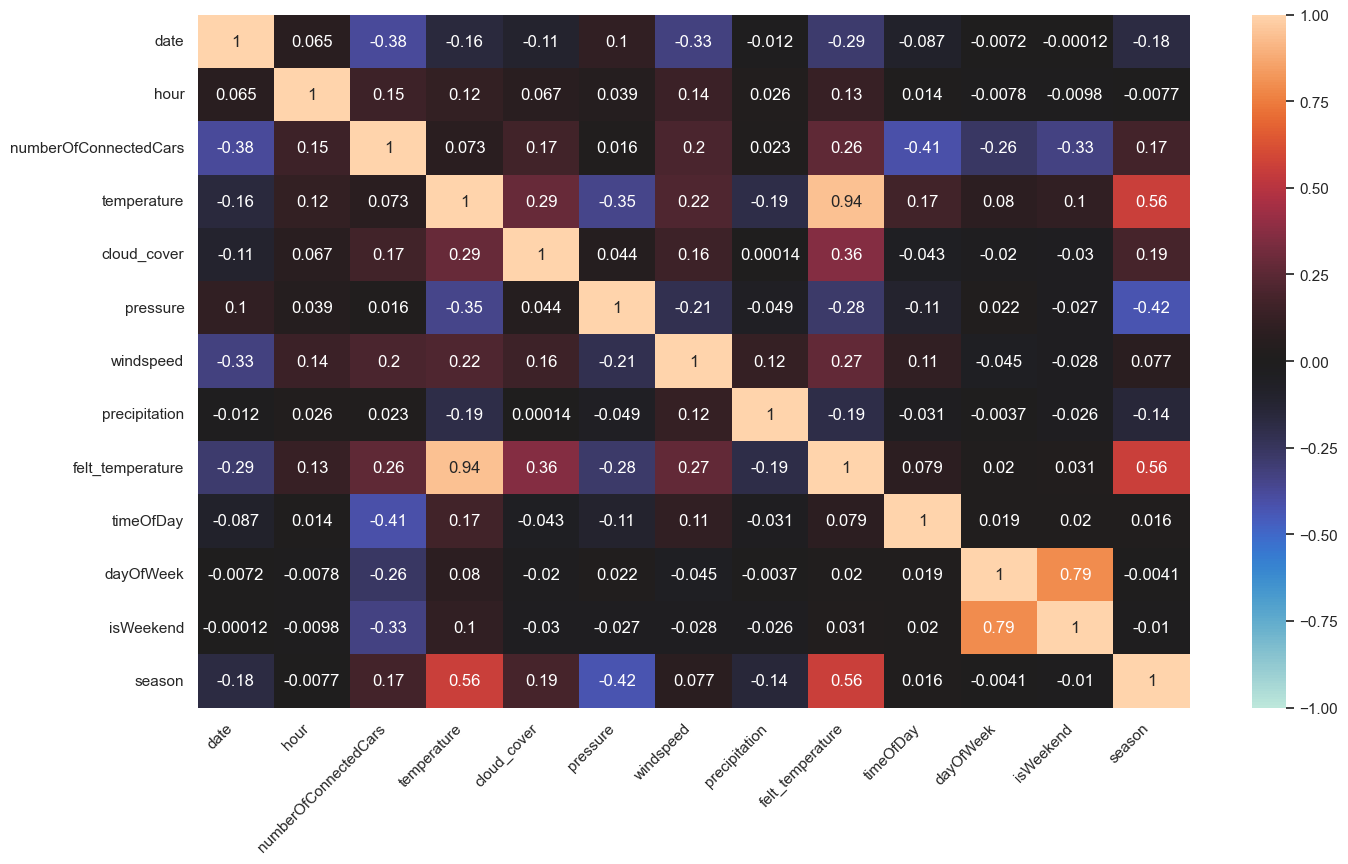

In [111]:
corrCars2 = dfPrediction1Site2.corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corrCars2, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

As we can see, the features temperature and felt_temperature are highly correlated with each other, which is why we will eliminate the felt_temperature feature. Since we have not so much features, we will keep all of the other features for prediction.

In [112]:
#drop feature felt_temperature
dfPrediction1Site2 = dfPrediction1Site2.drop('felt_temperature', axis=1)
dfPrediction1Site2

date  hour  numberOfConnectedCars  temperature  cloud_cover  \
0     2018-04-25     4                      1         12.0         26.0   
1     2018-04-25     5                      1         12.0         26.0   
2     2018-04-25     6                      3         12.0         26.0   
3     2018-04-25     7                      7         12.0         26.0   
4     2018-04-25     8                     22         12.6         26.0   
...          ...   ...                    ...          ...          ...   
16703 2020-12-30    17                      1         19.0         34.0   
16704 2020-12-30    18                      1         19.0         34.0   
16705 2020-12-31     8                      2          6.0         34.0   
16706 2020-12-31     9                      3          9.5         34.0   
16707 2020-12-31    10                      1         13.0         34.0   

       pressure  windspeed  precipitation  timeOfDay  dayOfWeek  isWeekend  \
0        989.11       11.0            0.0          5          2          0   
1        989.11       11.0            0.0          5          2          0   
2        989.44       11.0            0.0          5          2          0   
3        990.10        9.0            0.0          0          2          0   
4        990.10        9.0            0.0          0          2          0   
...         ...        ...            ...        ...        ...        ...   
16703    992.41        9.0            0.0          3          2          0   
16704    992.41        9.0            0.0          4          2          0   
16705    987.14        0.0            0.0          0          3          0   
16706    987.14       19.0            0.0          0          3          0   
16707    987.14       19.0            0.0          0          3          0   

       season  
0           2  
1           2  
2           2  
3           2  
4           2  
...       ...  
16703       1  
16704       1  
16705       1  
16706       1  
16707       1  

[16708 rows x 12 columns]

**Visualisation of dependencies:**

In [113]:
# hour of connected cars 
df21 = dfPrediction1Site2[['hour', 'numberOfConnectedCars']].groupby('hour').mean()

#temperature
x22 = dfPrediction1Site2['temperature'].values

#min_temperature
df23 = dfPrediction1Site2[['cloud_cover', 'numberOfConnectedCars']].groupby('cloud_cover').mean()

#pressure
x24 = dfPrediction1Site2['pressure'].values

#windspeed
df25 = dfPrediction1Site2[['windspeed', 'numberOfConnectedCars']].groupby('windspeed').mean()

#precipitation
df26 = dfPrediction1Site2[['precipitation', 'numberOfConnectedCars']].groupby('precipitation').mean()

#timeOfDay
df27 = dfPrediction1Site2[['timeOfDay', 'numberOfConnectedCars']].groupby('timeOfDay').mean()

#day of Week
df28 = dfPrediction1Site2[['dayOfWeek', 'numberOfConnectedCars']].groupby('dayOfWeek').mean()

# is weekend
df29 = dfPrediction1Site2[['isWeekend', 'numberOfConnectedCars']].groupby('isWeekend').mean()

#season
df210 = dfPrediction1Site2[['season', 'numberOfConnectedCars']].groupby('season').mean()

yscatter = dfPrediction1Site2['numberOfConnectedCars'].values 

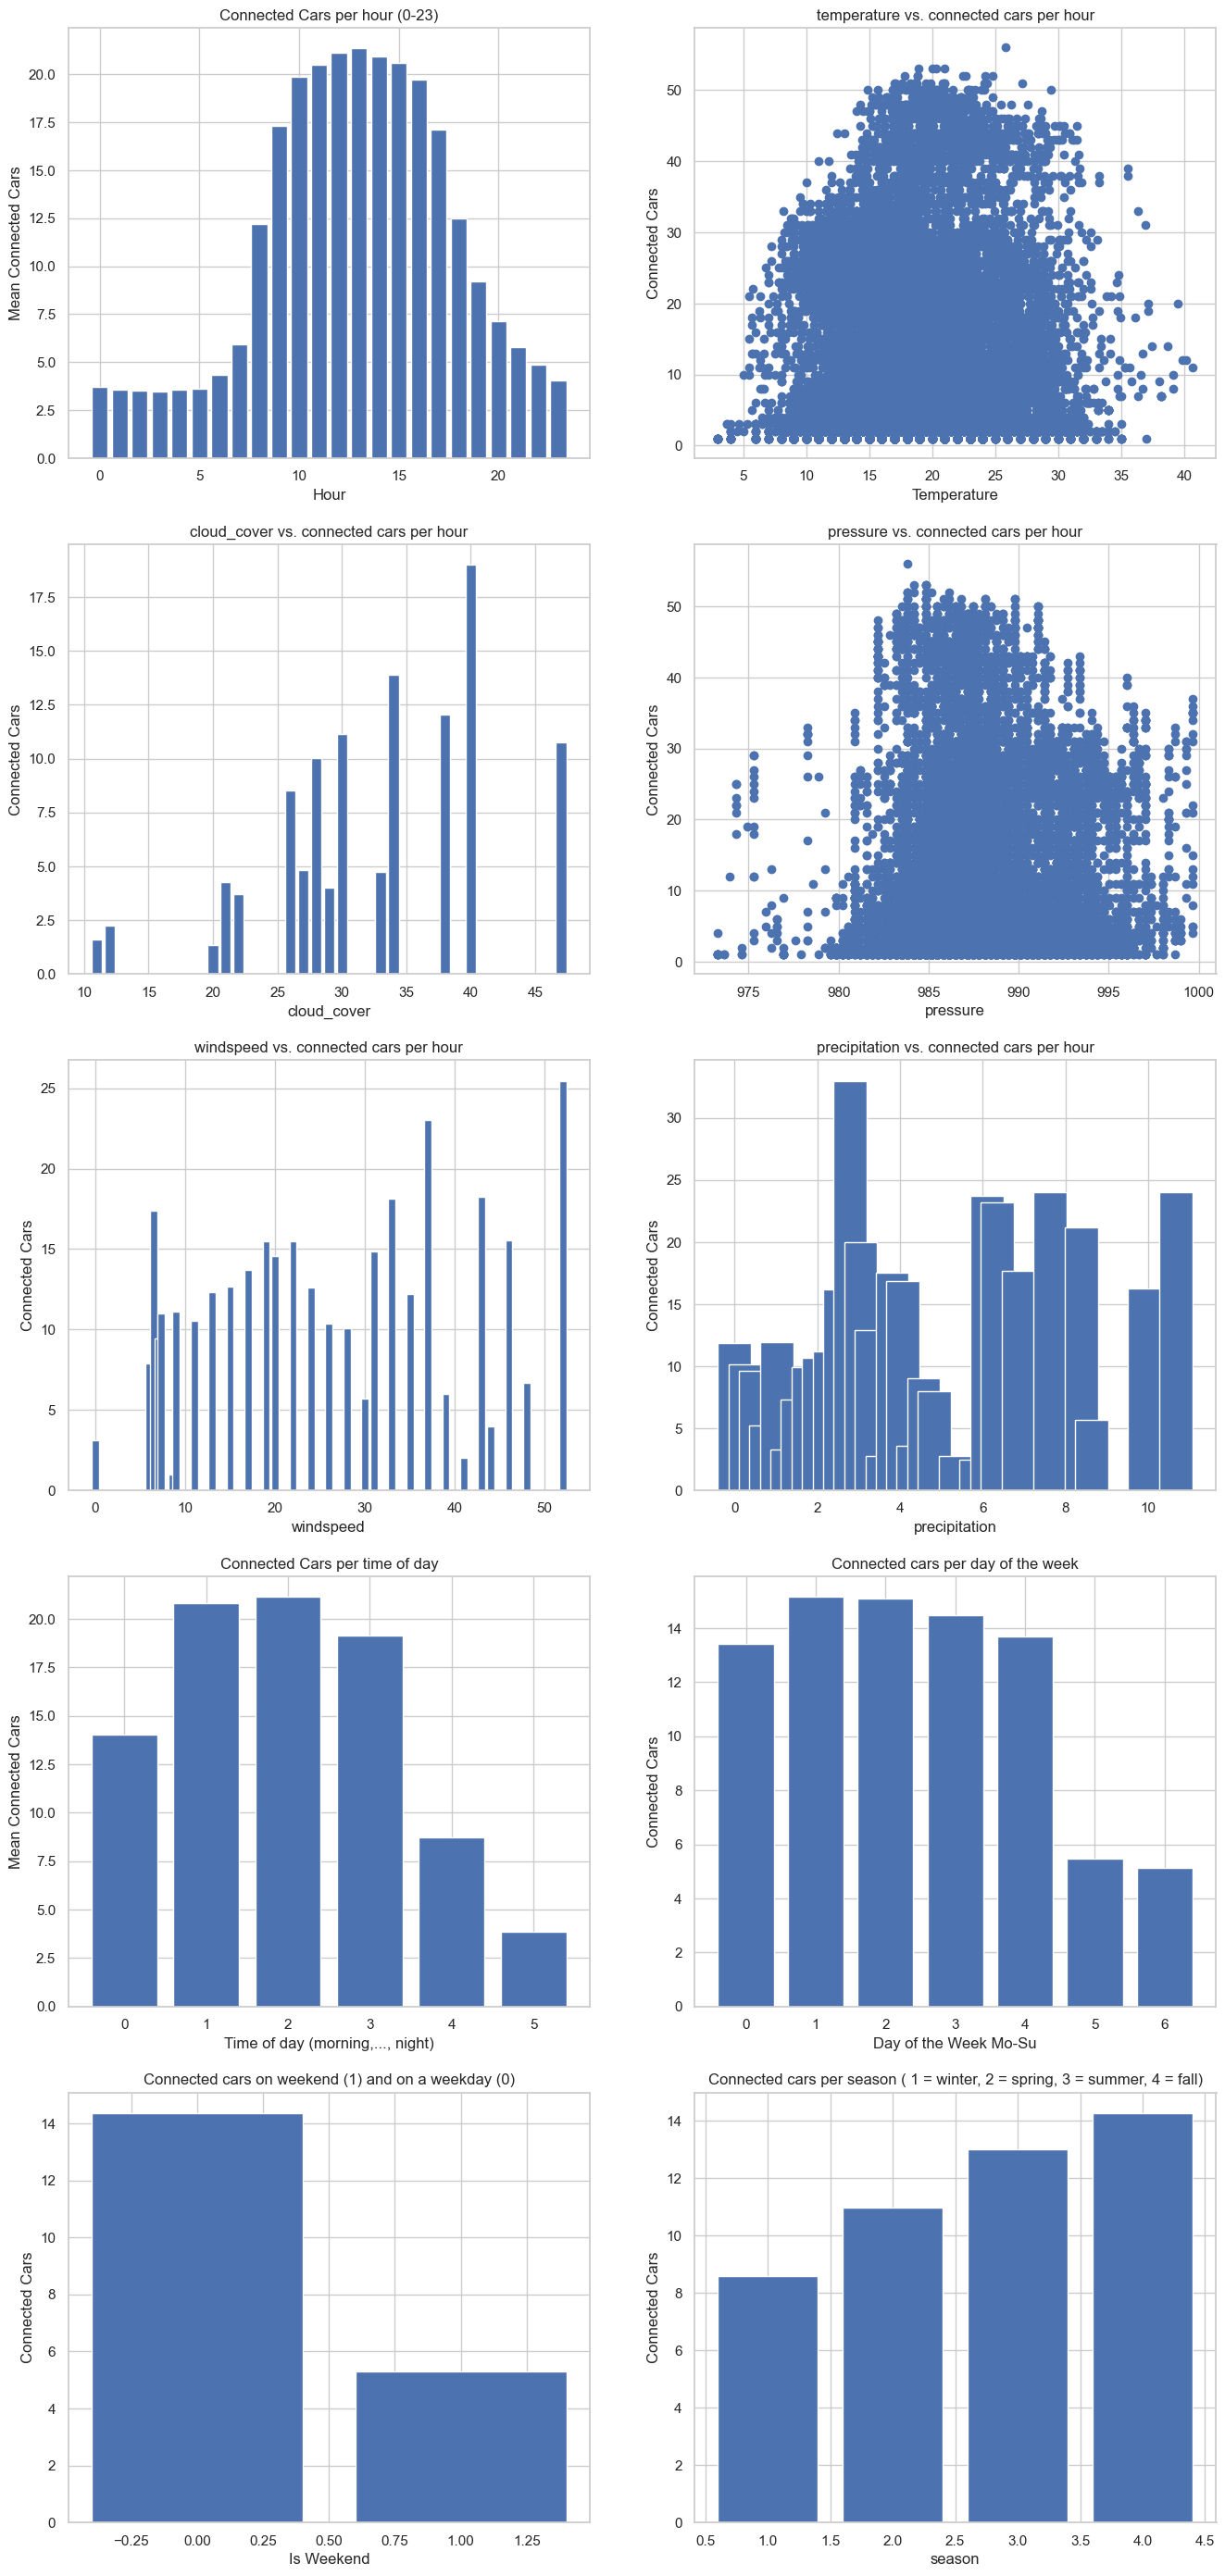

In [114]:
Fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize=(16, 35))

# subplot no. 1
plt.subplot(5,2,1)
plt.xlabel("Hour")
plt.ylabel("Mean Connected Cars")
plt.title("Connected Cars per hour (0-23)")
plt.bar(df21.index, df21["numberOfConnectedCars"])

# subplot no. 2
plt.subplot(5,2,2) 
plt.xlabel("Temperature")
plt.ylabel("Connected Cars")
plt.title("temperature vs. connected cars per hour")
plt.scatter(x22, yscatter)

# subplot no. 3
plt.subplot(5,2,3) 
plt.xlabel("cloud_cover")
plt.ylabel("Connected Cars")
plt.title("cloud_cover vs. connected cars per hour")
plt.bar(df23.index, df23["numberOfConnectedCars"])

# subplot no. 4
plt.subplot(5,2,4)
plt.xlabel("pressure")
plt.ylabel("Connected Cars")
plt.title("pressure vs. connected cars per hour")
plt.scatter(x24, yscatter)

# subplot no. 5
plt.subplot(5,2,5)
plt.xlabel("windspeed")
plt.ylabel("Connected Cars")
plt.title("windspeed vs. connected cars per hour")
plt.bar(df25.index, df25["numberOfConnectedCars"])

# subplot no. 6
plt.subplot(5,2,6)
plt.xlabel("precipitation")
plt.ylabel("Connected Cars")
plt.title("precipitation vs. connected cars per hour")
plt.bar(df26.index, df26["numberOfConnectedCars"])

# subplot no. 7
plt.subplot(5,2,7)
plt.xlabel("Time of day (morning,..., night)")
plt.ylabel("Mean Connected Cars")
plt.title("Connected Cars per time of day")
plt.bar(df27.index, df27["numberOfConnectedCars"])

# subplot no. 8
plt.subplot(5,2,8) 
plt.xlabel("Day of the Week Mo-Su")
plt.ylabel("Connected Cars")
plt.title("Connected cars per day of the week")
plt.bar(df28.index, df28["numberOfConnectedCars"])

# subplot no. 6
plt.subplot(5,2,9) 
plt.xlabel("Is Weekend")
plt.ylabel("Connected Cars")
plt.title("Connected cars on weekend (1) and on a weekday (0)")
plt.bar(df29.index, df29["numberOfConnectedCars"])

# subplot no. 7
plt.subplot(5,2,10)
plt.xlabel("season")
plt.ylabel("Connected Cars")
plt.title("Connected cars per season ( 1 = winter, 2 = spring, 3 = summer, 4 = fall)")
plt.bar(df210.index, df210["numberOfConnectedCars"])

plt.show()

## 4.2. Creation of Prediction Model

y = numberOfConnectedCars
xp = hour, temperature, cloud_cover, pressure, windspeed, precipitation, timeOfDay, dayOfWeek, isWeekend, season

### 4.2.1. Prediction for site 1

In [115]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


%matplotlib inline

**Normalize input values:**

In [116]:
#set output frame and input frame
x_Site1 = dfPrediction1Site1[['hour', 'temperature','cloud_cover', 'pressure', 'windspeed', 'precipitation', 'timeOfDay', 'dayOfWeek', 'isWeekend', 'season']]
y_Site1 = dfPrediction1Site1['numberOfConnectedCars']

In [117]:
# Normalize the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_norm_Site1 = scaler.fit_transform(x_Site1)

**Split the dataset in trainset, validationset and testset (50-20-30):**

In [118]:
#split the data set in 70% training set and 30% testing set
x_train_Site1, x_test_Site1, y_train_Site1, y_test_Site1 = train_test_split(x_norm_Site1, y_Site1, test_size=0.3,random_state=42)

# save the combination of training and validation set in extra variables
x_train_val_Site1 = x_train_Site1
y_train_val_Site1 = y_train_Site1

#split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train_Site1, x_val_Site1, y_train_Site1, y_val_Site1 = train_test_split(x_train_Site1, y_train_Site1, test_size=(0.2/0.7), random_state = 42)

**We now have the following datasets:**
- x_train_Site1, y_train_Site1 → 50% input features for training the model
- x_val_Site1, y_val_Site1 → 20% to select hyperparameters
- x_test_Site1, y_test_Site1 → 30% to control the accurancy of the model                                                    

**Typical steps of a regression:**
1. Divide data into training set, holdout set, and test set
2. Train algorithm on training set (i.e., to learn parameters), use holdout set to select hyperparameters
4. (Optional) retrain system on training + holdout
5. Evaluate performance on test set

#### 4.2.1.1 `Random Forest Regression`

In [119]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

**Finding the best parameters:**

In [120]:
rf_Site1 = RandomForestRegressor(random_state =42)
rf_param_Site1 = {'n_estimators': np.arange(25,150,25), 'max_depth': np.arange(1,11,2), 'min_samples_leaf':np.arange(2,15,3)}

gs_rf_Site1 = GridSearchCV(rf_Site1, rf_param_Site1, cv=3)
gs_rf_Site1.fit(x_train_val_Site1, y_train_val_Site1)
best_params_Site1 = gs_rf_Site1.best_params_

**Train the model:**

In [121]:
# Fit regression model
rf_2_Site1 = RandomForestRegressor(n_estimators = best_params_Site1['n_estimators'], max_depth = best_params_Site1['max_depth'], min_samples_leaf = best_params_Site1['min_samples_leaf'], random_state=0)
model_rf_Site1 = rf_2_Site1.fit(x_train_val_Site1, y_train_val_Site1)

**Evaluate the performance of the model:**

In [122]:
# Predict
y_predict_rf_Site1 = model_rf_Site1.predict(x_test_Site1)

#Test set performance
mae_rf_Site1 = mean_absolute_error(y_test_Site1, y_predict_rf_Site1)
mse_rf_Site1 = mean_squared_error(y_test_Site1, y_predict_rf_Site1)**(0.5)

print('Test set performance:')
print('MAE: ', mae_rf_Site1)
print('RMSE: ', mse_rf_Site1)
print("Accuracy:", round((1-(mae_rf_Site1/dfPrediction1Site1["numberOfConnectedCars"].mean()))*100,2), "%")

Test set performance:
MAE:  6.986970414518188
RMSE:  10.995522495120309
Accuracy: 62.5 %


#### 4.2.1.2 `Artificial Neural Network`

Before running you have to install tensorflow:

`pip install tensorflow`

**Building the model with the functional API of Keras:**

In [123]:
#pip install tensorflow

In [124]:
# import keras libraries
import tensorflow
from tensorflow import keras
from keras import layers

In [125]:
def build_model_Site1(hp):
    # Input Layer
    inputs = keras.Input(shape=(10,))

    # Hidden Layers
    ## First Hidden Layer
    dense = layers.Dense(units=hp.Int('hidden_layer_1_units', min_value=32, max_value=256, step=32), activation='relu')
    x = dense(inputs)
    
    ## Possible additional hidden layers
    for i in range(hp.Int('total_added_hidden_layers', 0, 10)):
        x = layers.Dense(units=hp.Int(f'hidden_layer_{i+2}_units', min_value=32, max_value=256, step=32), activation='relu')(x)
        
    # Output Layer
    outputs = layers.Dense(1, activation='relu')(x)

    # Instantiate the model
    model_ann = keras.Model(inputs, outputs, name='car_demand_site1')
    
    # Compile the model
    model_ann.compile(optimizer='Adamax', loss='mean_squared_error') 
    
    return model_ann

**Use hyperparameter tuning to find the best model:**

You need to install keras_tuner first: You can use `pip install keras-tuner`

In [126]:
#pip install keras-tuner

In [127]:
import keras_tuner
from keras_tuner.tuners import Hyperband
import IPython

Instantiate a tuner for hypertuning:  





We choose the HyperBand Tuner of Keras

In [128]:
tuner_Site1 = Hyperband(
    build_model_Site1,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    directory = "D:/Keras",
    project_name = 't1',
    overwrite = True # deletes old LOG's
    )

Show a summary of the search space:

In [129]:
tuner_Site1.search_space_summary()

Search space summary
Default search space size: 2
hidden_layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
total_added_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 10, 'step': 1, 'sampling': 'linear'}


To clear the training outputs after each training step define a callback:

In [130]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Hyperparameter Search:

In [131]:
tuner_Site1.search(
    x_train_Site1,
    y_train_Site1,
    validation_data=(x_val_Site1,y_val_Site1),
    callbacks = [ClearTrainingOutput()]
    )

Trial 30 Complete [00h 00m 14s]
val_loss: 142.83303833007812

Best val_loss So Far: 121.5157241821289
Total elapsed time: 00h 04m 03s


Show a summary of the results which presents the best model, the hyperparameters and the metrics:

In [132]:
tuner_Site1.results_summary()

Results summary
Results in D:/Keras\t1
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0024 summary
Hyperparameters:
hidden_layer_1_units: 160
total_added_hidden_layers: 8
hidden_layer_2_units: 256
hidden_layer_3_units: 96
hidden_layer_4_units: 32
hidden_layer_5_units: 128
hidden_layer_6_units: 192
hidden_layer_7_units: 96
hidden_layer_8_units: 256
hidden_layer_9_units: 160
hidden_layer_10_units: 192
hidden_layer_11_units: 96
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
Score: 121.5157241821289

Trial 0025 summary
Hyperparameters:
hidden_layer_1_units: 224
total_added_hidden_layers: 7
hidden_layer_2_units: 160
hidden_layer_3_units: 128
hidden_layer_4_units: 224
hidden_layer_5_units: 192
hidden_layer_6_units: 160
hidden_layer_7_units: 96
hidden_layer_8_units: 160
hidden_layer_9_units: 256
hidden_layer_10_units: 128
hidden_layer_11_units: 96
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tu

Get optimal hyperparameters:

In [133]:
ann_best_hps_Site1 = tuner_Site1.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is {ann_best_hps_Site1.get('hidden_layer_1_units')} 
and the total number of hidden layers is {ann_best_hps_Site1.get('total_added_hidden_layers')+1}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is 160 
and the total number of hidden layers is 9.



Get the best model:

In [134]:
model_ann_Site1 = tuner_Site1.get_best_models(num_models=1)[0]

Show a summary of the model:

In [135]:
model_ann_Site1.summary()

Model: "car_demand_site1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 160)               1760      
                                                                 
 dense_1 (Dense)             (None, 256)               41216     
                                                                 
 dense_2 (Dense)             (None, 96)                24672     
                                                                 
 dense_3 (Dense)             (None, 32)                3104      
                                                                 
 dense_4 (Dense)             (None, 128)               4224      
                                                                 
 dense_5 (Dense)             (None, 192)          

Plot the model as a graph:

You need to install pydot and graphivz. You can use: `conda install -c anaconda graphviz` and `conda install -c conda-forge python-graphviz` sequentially and `conda install -c conda-forge pydot`

In [136]:
#pip install pydot

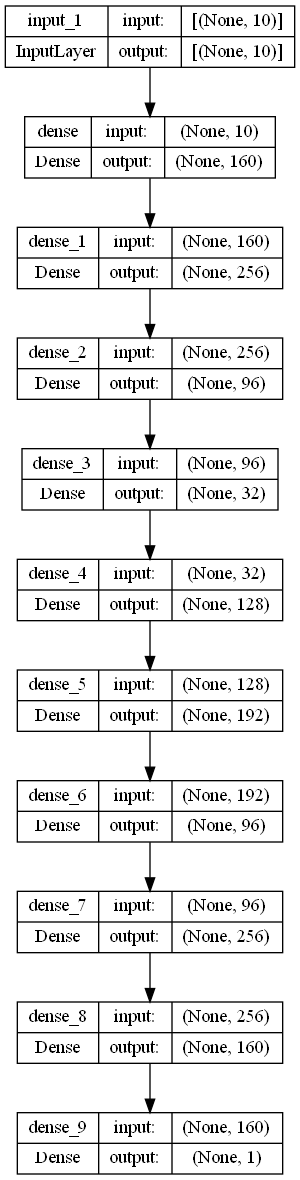

In [137]:
keras.utils.plot_model(model_ann_Site1, 'model_ann_car_demand_site1.png', show_shapes=True)

**Train the model:**

In [138]:
# Define a callback which stops earlier when their is no further improvement and which avoids overfitting
early_stopping_Site1 = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50,
    restore_best_weights=True 
    )

In [139]:
# Define a callback which reduces the learning rate when there is  o further improvement
reduce_learing_rate_Site1 = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    patience=30, 
    min_lr = 0.00001
    )

In [140]:
model_ann_Site1.fit(x_train_Site1, y_train_Site1, epochs=500, validation_data=(x_val_Site1,y_val_Site1), callbacks=[early_stopping_Site1, reduce_learing_rate_Site1])

Epoch 1/500
187/187 [==============================] - 2s 4ms/step - loss: 89.3838 - val_loss: 118.3433 - lr: 0.0010
Epoch 2/500
187/187 [==============================] - 1s 3ms/step - loss: 91.1092 - val_loss: 117.4662 - lr: 0.0010
Epoch 3/500
187/187 [==============================] - 1s 3ms/step - loss: 86.3853 - val_loss: 117.8588 - lr: 0.0010
Epoch 4/500
187/187 [==============================] - 1s 3ms/step - loss: 83.5955 - val_loss: 119.2309 - lr: 0.0010
Epoch 5/500
187/187 [==============================] - 1s 3ms/step - loss: 81.8960 - val_loss: 116.6805 - lr: 0.0010
Epoch 6/500
187/187 [==============================] - 1s 3ms/step - loss: 79.8093 - val_loss: 118.7135 - lr: 0.0010
Epoch 7/500
187/187 [==============================] - 1s 3ms/step - loss: 77.3496 - val_loss: 117.0903 - lr: 0.0010
Epoch 8/500
187/187 [==============================] - 1s 3ms/step - loss: 77.5239 - val_loss: 113.8349 - lr: 0.0010
Epoch 9/500
187/187 [==============================] - 1s 4ms/st

**Evaluate the performance of the model:**

In [141]:
pred_ann_Site1 = model_ann_Site1.predict(x_test_Site1)

# Calculate MAE and RMSE
mae_ann_Site1 = mean_absolute_error(y_test_Site1,pred_ann_Site1)
rmse_ann_Site1 = mean_squared_error(y_test_Site1,pred_ann_Site1)**0.5

print("MAE:", mae_ann_Site1)
print("RMSE:", rmse_ann_Site1)
print("Accuracy:", round((1-(mae_ann_Site1/dfPrediction1Site1["numberOfConnectedCars"].mean()))*100,2), "%")

113/113 [==============================] - 0s 2ms/step
MAE: 4.9062108842607195
RMSE: 9.451692742631291
Accuracy: 73.67 %


### 4.2.2. Prediction for site 2

All necessary installations and imports are shown in the prediction of site 1 and are not mentioned again here.

**Normalize input values:**

In [142]:
#set output frame and input frame
x_Site2 = dfPrediction1Site2[['hour', 'temperature','cloud_cover', 'pressure', 'windspeed', 'precipitation', 'timeOfDay', 'dayOfWeek', 'isWeekend', 'season']]
y_Site2 = dfPrediction1Site2['numberOfConnectedCars']

In [143]:
# Normalize the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_norm_Site2 = scaler.fit_transform(x_Site2)

**Split the dataset in trainset, validationset and testset (50-20-30):**

In [144]:
#split the data set in 70% training set and 30% testing set
x_train_Site2, x_test_Site2, y_train_Site2, y_test_Site2 = train_test_split(x_norm_Site2, y_Site2, test_size=0.3,random_state=42)

# save the combination of training and validation set in extra variables
x_train_val_Site2 = x_train_Site2
y_train_val_Site2 = y_train_Site2

#split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train_Site2, x_val_Site2, y_train_Site2, y_val_Site2 = train_test_split(x_train_Site2, y_train_Site2, test_size=(0.2/0.7), random_state = 42)

**We now have the following datasets:**
- x_train_Site2, y_train_Site2 &rarr; 50% input features for training the model
- x_val_Site2, y_val_Site2 &rarr; 20% to select hyperparameters
- x_test_Site2, y_test_Site2 &rarr; 30% to control the accurancy of the model

**Typical steps of a regression:**
1. Divide data into training set, holdout set, and test set
2. Train algorithm on training set (i.e., to learn parameters), use holdout set to select hyperparameters
4. (Optional) retrain system on training + holdout
5. Evaluate performance on test set

#### 4.2.2.1. `Random Forest Regression`

**Finding the best parameters:**

In [145]:
rf_Site2 = RandomForestRegressor(random_state =42)
rf_param_Site2 = {'n_estimators': np.arange(25,150,25), 'max_depth': np.arange(1,11,2), 'min_samples_leaf':np.arange(2,15,3)}

gs_rf_Site2 = GridSearchCV(rf_Site2, rf_param_Site2, cv=3)
gs_rf_Site2.fit(x_train_val_Site2, y_train_val_Site2)
best_params_Site2 = gs_rf_Site2.best_params_

**Train the model:**

In [146]:
# Fit regression model
rf_2_Site2 = RandomForestRegressor(n_estimators = best_params_Site2['n_estimators'], max_depth = best_params_Site2['max_depth'], min_samples_leaf = best_params_Site2['min_samples_leaf'], random_state=0)
model_rf_Site2 = rf_2_Site2.fit(x_train_val_Site2, y_train_val_Site2)

**Evaluate the performance of the model:**

In [147]:
# Predict
y_predict_rf_Site2 = model_rf_Site2.predict(x_test_Site2)

#Test set performance
mae_rf_Site2 = mean_absolute_error(y_test_Site2, y_predict_rf_Site2)
mse_rf_Site2 = mean_squared_error(y_test_Site2, y_predict_rf_Site2)**(0.5)

print('Test set performance:')
print('MAE: ', mae_rf_Site2)
print('RMSE: ', mse_rf_Site2)
print("Accuracy:", round((1-(mae_rf_Site2/dfPrediction1Site2["numberOfConnectedCars"].mean()))*100,2), "%")

Test set performance:
MAE:  4.187222259945302
RMSE:  6.560247182993115
Accuracy: 64.42 %


#### 4.2.2.2. `Artificial Neural Network`

**Building the model with the functional API of Keras:**

In [148]:
def build_model_Site2(hp):
    # Input Layer
    inputs = keras.Input(shape=(10,))

    # Hidden Layers
    ## First Hidden Layer
    dense = layers.Dense(units=hp.Int('hidden_layer_1_units', min_value=32, max_value=256, step=32), activation='relu')
    x = dense(inputs)
    
    ## Possible additional hidden layers
    for i in range(hp.Int('total_added_hidden_layers', 0, 10)):
        x = layers.Dense(units=hp.Int(f'hidden_layer_{i+2}_units', min_value=32, max_value=256, step=32), activation='relu')(x)
        
    # Output Layer
    outputs = layers.Dense(1, activation='relu')(x)

    # Instantiate the model
    model_ann = keras.Model(inputs, outputs, name='car_demand_site2')
    
    # Compile the model
    model_ann.compile(optimizer='Adamax', loss='mean_squared_error') 
    
    return model_ann

**Use hyperparameter tuning to find the best model:**

Instantiate a tuner for hypertuning:  

We choose the HyperBand Tuner of Keras

In [149]:
tuner_Site2 = Hyperband(
    build_model_Site2,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    directory = "D:/Keras",
    project_name = 't2',
    overwrite = True # deletes old LOG's
    )

Show a summary of the search space:

In [150]:
tuner_Site2.search_space_summary()

Search space summary
Default search space size: 2
hidden_layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
total_added_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 10, 'step': 1, 'sampling': 'linear'}


To clear the training outputs after each training step define a callback:

In [151]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Hyperparameter Search:

In [152]:
tuner_Site2.search(
    x_train_Site2,
    y_train_Site2,
    validation_data=(x_val_Site2,y_val_Site2),
    callbacks = [ClearTrainingOutput()]
    )

Trial 30 Complete [00h 00m 23s]
val_loss: 42.8876838684082

Best val_loss So Far: 40.17641830444336
Total elapsed time: 00h 04m 55s


Show a summary of the results which presents the best model, the hyperparameters and the metrics:

In [153]:
tuner_Site2.results_summary()

Results summary
Results in D:/Keras\t2
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0026 summary
Hyperparameters:
hidden_layer_1_units: 128
total_added_hidden_layers: 8
hidden_layer_2_units: 224
hidden_layer_3_units: 128
hidden_layer_4_units: 256
hidden_layer_5_units: 160
hidden_layer_6_units: 224
hidden_layer_7_units: 160
hidden_layer_8_units: 256
hidden_layer_9_units: 128
hidden_layer_10_units: 64
hidden_layer_11_units: 128
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 40.17641830444336

Trial 0024 summary
Hyperparameters:
hidden_layer_1_units: 256
total_added_hidden_layers: 6
hidden_layer_2_units: 192
hidden_layer_3_units: 224
hidden_layer_4_units: 224
hidden_layer_5_units: 128
hidden_layer_6_units: 160
hidden_layer_7_units: 128
hidden_layer_8_units: 96
hidden_layer_9_units: 32
hidden_layer_10_units: 96
hidden_layer_11_units: 64
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
S

Get optimal hyperparameters:

In [154]:
ann_best_hps_Site1 = tuner_Site1.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is {ann_best_hps_Site1.get('hidden_layer_1_units')} 
and the total number of hidden layers is {ann_best_hps_Site1.get('total_added_hidden_layers')+1}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is 160 
and the total number of hidden layers is 9.



Get the best model:

In [155]:
model_ann_Site2 = tuner_Site2.get_best_models(num_models=1)[0]

Show a summary of the model:

In [156]:
model_ann_Site2.summary()

Model: "car_demand_site2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 224)               28896     
                                                                 
 dense_2 (Dense)             (None, 128)               28800     
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 160)               41120     
                                                                 
 dense_5 (Dense)             (None, 224)          

Plot the model as a graph:

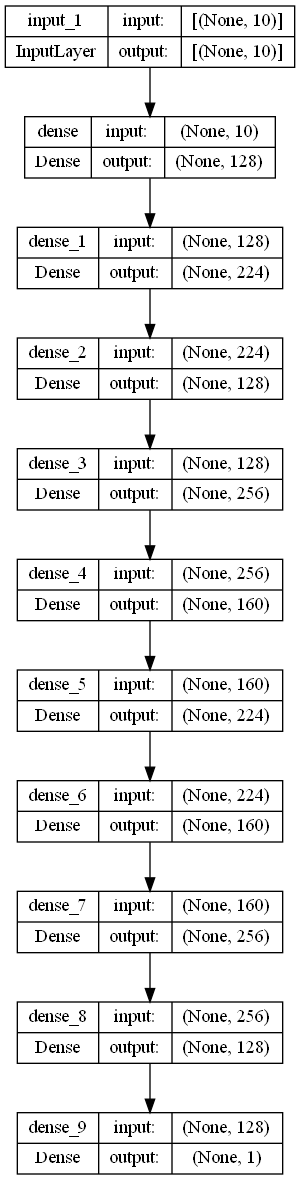

In [157]:
keras.utils.plot_model(model_ann_Site2, 'model_ann_car_demand_site2.png', show_shapes=True)

**Train the model:**

In [158]:
# Define a callback which stops earlier when their is no further improvement and which avoids overfitting
early_stopping_Site2 = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50, 
    restore_best_weights=True 
    )

In [159]:
# Define a callback which reduces the learning rate when there is  o further improvement
reduce_learing_rate_Site2 = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    patience=30, 
    min_lr = 0.00001
    )

In [160]:
model_ann_Site2.fit(x_train_Site2, y_train_Site2, epochs=500, validation_data=(x_val_Site2,y_val_Site2), callbacks=[early_stopping_Site2, reduce_learing_rate_Site2])

Epoch 1/500
262/262 [==============================] - 3s 4ms/step - loss: 31.4259 - val_loss: 41.1163 - lr: 0.0010
Epoch 2/500
262/262 [==============================] - 1s 4ms/step - loss: 30.3852 - val_loss: 39.3551 - lr: 0.0010
Epoch 3/500
262/262 [==============================] - 1s 4ms/step - loss: 29.3912 - val_loss: 40.7381 - lr: 0.0010
Epoch 4/500
262/262 [==============================] - 1s 4ms/step - loss: 28.8903 - val_loss: 37.9015 - lr: 0.0010
Epoch 5/500
262/262 [==============================] - 1s 4ms/step - loss: 28.4673 - val_loss: 37.1611 - lr: 0.0010
Epoch 6/500
262/262 [==============================] - 1s 4ms/step - loss: 27.4152 - val_loss: 37.2608 - lr: 0.0010
Epoch 7/500
262/262 [==============================] - 1s 4ms/step - loss: 26.8969 - val_loss: 37.2291 - lr: 0.0010
Epoch 8/500
262/262 [==============================] - 1s 4ms/step - loss: 25.8778 - val_loss: 36.1270 - lr: 0.0010
Epoch 9/500
262/262 [==============================] - 1s 4ms/step - los

**Evaluate the performance of the model:**

In [161]:
pred_ann_Site2 = model_ann_Site2.predict(x_test_Site2)

# Calculate MAE and RMSE
mae_ann_Site2 = mean_absolute_error(y_test_Site2,pred_ann_Site2)
rmse_ann_Site2 = mean_squared_error(y_test_Site2,pred_ann_Site2)**0.5

print("MAE:", mae_ann_Site2)
print("RMSE:", rmse_ann_Site2)
print("Accuracy:", round((1-(mae_ann_Site2/dfPrediction1Site2["numberOfConnectedCars"].mean()))*100,2), "%")

157/157 [==============================] - 0s 2ms/step
MAE: 3.227776689858059
RMSE: 5.651575971244228
Accuracy: 72.58 %
